## Deadline

Wednesday, November 22, 2017, 11:59PM

## Important notes

- When you push your Notebook to GitHub, all the cells must already have been evaluated.
- Don't forget to add a textual description of your thought process and of any assumptions you've made.
- Please write all your comments in English, and use meaningful variable names in your code.

# Table of Contents
 <p>
 <div class="lev1"><a href="#Question-1:-Propensity-score-matching"><span class="toc-item-num">Question 1: Propensity score matching</span></a></div>
 <div class="lev1"><a href="#1.-A-naive-analysis"><span class="toc-item-num">1. A naive analysis</span></a></div>
 <div class="lev1"><a href="#2.-A-closer-look-at-the-data"><span class="toc-item-num">2. A closer look at the data</span></a></div>
 <div class="lev1"><a href="#3.-A-propensity-score-model"><span class="toc-item-num">3. A propensity score model</span></a></div>
 <div class="lev1"><a href="#4.-Balancing-the-dataset-via-matching"><span class="toc-item-num">4. Balancing the dataset via matching</span></a></div>
 <div class="lev1"><a href="#5.-Balancing-the-groups-further"><span class="toc-item-num">5. Balancing the groups further</span></a></div>
 <div class="lev1"><a href="#6.-A-less-naive-analysis"><span class="toc-item-num"> 6. A less naive analysis</span></a></div>
 <div class="lev1"><a href="#Question-2:-Applied-ML"><span class="toc-item-num">Question 2: Applied ML</span></a></div>
 </p>

## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

## Solution 1.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import branca.colormap as cm
import networkx as nx
from networkx.algorithms import bipartite
%matplotlib inline

pd.options.display.max_rows = 999
color_scheme = ['#f1a340', '#998ec3']
sns.set_palette(sns.color_palette(color_scheme))
sns.set_style('darkgrid')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.edgecolor'] = '0.15'
plt.rcParams['axes.linewidth']  = 1.25

In [2]:
#load the dataframe
job_training = pd.read_csv('lalonde.csv', index_col = 'id')

After we imported the data from Robert LaLonde's study from the *lalonde.csv* file, we decided to add new column named *white* which represents the last possible set of dummy values for the *race/ethnicity* feature. We assume that a selected person has only one race with which he or she indentifies, so the value of the *white* column for each row is set to 1 only when the values in columns *black* and *hispan* are both 0.

In [3]:
#add white column
job_training['white'] = np.logical_not(job_training['black'] | job_training['hispan']).astype(int)
#reorder columns
job_training = job_training[['treat', 'age', 'educ', 'black', 
                             'hispan', 'white', 'married', 'nodegree',
                             're74', 're75', 're78']]
job_training.head()

,treat,age,educ,black,hispan,white,married,nodegree,re74,re75,re78
id,,,,,,,,,,,
NSW1,1,37,11,1,0,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,0,1,0.0,0.0,289.7899


In order to make a DataFrame which is more adequate for a naive analysis and visualisation of the participant features we created the *job_training_cat* DataFrame. In this DataFrame we merged the dummy features that represent *Ethnicity* into one categorical column. We also transformed the *treat*, *married* and *nodegree* columns into categorical ones in order to make the data easier to interpret. We renamed the columns to more understandable terms (for example outcome variable *re78* is called *1978 income* after change).

In [4]:
#new dataframe
job_training_cat = job_training.copy()
#merge and drop dummy features
job_training_cat['Ethnicity'] = job_training[['black','hispan','white']].idxmax(axis = 1).astype('category')
job_training_cat.drop(['black','hispan','white'], axis = 1, inplace = True)
#transform to categories
job_training_cat['treat'] = job_training_cat['treat'].map({0:'Control', 1:'Treated'}).astype('category')
job_training_cat['married'] = job_training_cat['married'].map({0:'Not married', 1:'Maried'}).astype('category')
job_training_cat['nodegree'] = job_training_cat['nodegree'].map({0:'Degree', 1:'No degree'}).astype('category')
#rename columns
job_training_cat.rename(columns = {'treat': 'Treatment',
                                        'age': 'Age',
                                        'educ': 'Education length',
                                        're74': '1974 income',
                                        're75': '1975 income',
                                        're78': '1978 income',
                                        'married': 'Marital status',
                                        'nodegree': 'Degree status'}, inplace = True)
#rename values in Ethnicity column
job_training_cat['Ethnicity'].replace({'black': 'Black',
                                       'hispan': 'Hispanic',
                                       'white': 'White'}, inplace = True)
#reorder columns
job_training_cat = job_training_cat[['Treatment', 'Age', 'Education length', 
                                     'Ethnicity', 'Marital status', 'Degree status',
                                     '1974 income', '1975 income', '1978 income']]

job_training_cat.head()

,Treatment,Age,Education length,Ethnicity,Marital status,Degree status,1974 income,1975 income,1978 income
id,,,,,,,,,
NSW1,Treated,37,11,Black,Maried,No degree,0.0,0.0,9930.0460
NSW2,Treated,22,9,Hispanic,Not married,No degree,0.0,0.0,3595.8940
NSW3,Treated,30,12,Black,Not married,Degree,0.0,0.0,24909.4500
NSW4,Treated,27,11,Black,Not married,No degree,0.0,0.0,7506.1460
NSW5,Treated,33,8,Black,Not married,No degree,0.0,0.0,289.7899


We tried to further investigate possible correlations between continuous features, that could influence our results and conclusions, by creating a heatmap plot.

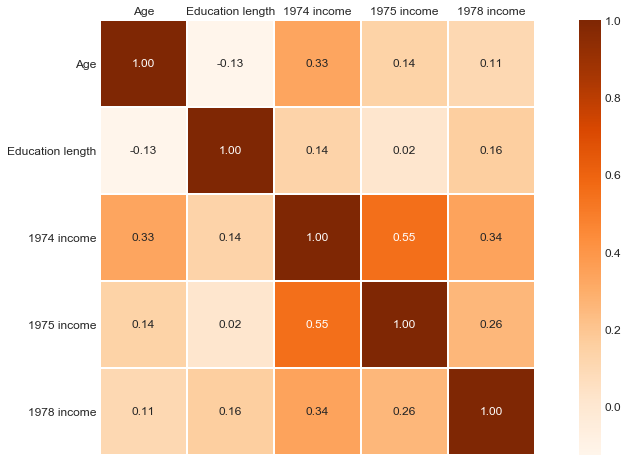

In [5]:
ax = sns.heatmap(job_training_cat.corr(), square = True, annot = True, fmt = '.2f', linewidths = '1', cmap = 'Oranges')
#move x ticks to the top
ax.get_xaxis().set_ticks_position('top')

The heatmap demonstrated that the correlations between the continuous features of the *job_training_cat* DataFrame are mostly low or medium. The only observed high correlation appears between features *1974 income* and *1975 income* which is reasonable considering that most of the incomes of already employed people are based on their previous salaries and are usually only gradually increased or decreased.

In this step we created two helper DataFrames, one that consists only from the participants of the study - *job_training_treated*, and the other which contains only people from the control group - *job_training_control*. Using the *describe()* function both of the DataFrames' statistical properties were displayed and merged into DataFrame *comparison*. 

In [6]:
#helper dataframes
job_training_control = job_training_cat.loc[job_training_cat['Treatment'] == 'Control']
job_training_treated = job_training_cat.loc[job_training_cat['Treatment'] == 'Treated']
#dataframe for statistical comparison
comparison = pd.concat([job_training_control.describe(), job_training_treated.describe()], axis=1, keys=['Control', 'Treated'])
comparison.columns = comparison.columns.swaplevel(0, 1)
comparison.sort_index(axis=1, inplace=True)
comparison

1974 income                 1975 income                 1978 income  \
            Control       Treated       Control       Treated       Control   
count    429.000000    185.000000    429.000000    185.000000    429.000000   
mean    5619.236506   2095.573689   2466.484443   1532.055314   6984.169742   
std     6788.750796   4886.620353   3291.996183   3219.250870   7294.161791   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000    220.181300   
50%     2547.047000      0.000000   1086.726000      0.000000   4975.505000   
75%     9277.128000   1291.468000   3881.419000   1817.284000  11688.820000   
max    25862.320000  35040.070000  18347.230000  25142.240000  25564.670000   

                            Age             Education length              
            Treated     Control     Treated          Control     Treated  
count    185.000000  429.000000  185.000000       429.000000  185.000000  
mean    6349.143530   28.030303   25.816216        10.235431   10.345946  
std     7867.402218   10.786653    7.155019         2.855238    2.010650  
min        0.000000   16.000000   17.000000         0.000000    4.000000  
25%      485.229800   19.000000   20.000000         9.000000    9.000000  
50%     4232.309000   25.000000   25.000000        11.000000   11.000000  
75%     9642.999000   35.000000   29.000000        12.000000   12.000000  
max    60307.930000   55.000000   48.000000        18.000000   16.000000

From the statistical properties of the two groups we can firstly observe that the control group contains information about 429 persons, while treated group containes only information about 185 persons. The age and education length features seem to be quite equalized with similar means, and not too large standard deviations. The means of the incomes in both 1974 and 1975 are significantly larger in the control group than the coresponding means of the treated group. If we concluded our research at this step, only considering the means and their standard errors - *1978 income*, we would have to say that the job training program was not effective and that the treated subjects show no further improvement comparing to the control subjects.

In the end of our naive analysis we plotted the distribution of the outcome feature *1978 income* split into two groups according to the *Treatment* variable. We fixed the maximum values on both x and y axis on both graphs (we made the axes shared between the graphs) so that the comparison between the distributions is possible without any false assumptions.

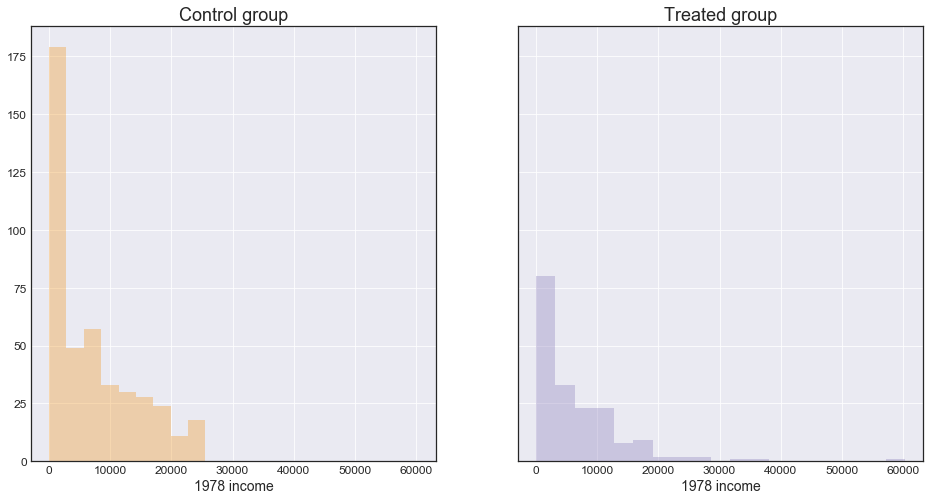

In [7]:
#create two plots side by side with shared axes
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharey = True, sharex = True)
#plot control group
sns.distplot(job_training_cat.loc[job_training_cat['Treatment'] == 'Control']['1978 income'], kde = False, color = '#f1a340', ax = ax1)
ax1.set_title('Control group')
#plot treated group
sns.distplot(job_training_cat.loc[job_training_cat['Treatment'] == 'Treated']['1978 income'], kde = False, color = '#998ec3', ax = ax2)
ax2.set_title('Treated group')

Unfortunately, not many conclusions can be made from the simple distribution plots of the *1978* feature. Again, the obvious point is that there is a lot more subjects that belong to the control group than the ones that belong to the treated group. In both groups the largest amount of people is unemployed or volunteering. We can also see that there is many more people that have the income between 15000 and 25000 units in the control group, and that there is one extreme outlier in the treated group that has income of 60000 units and influences the mean of the group. After this visualisation we would also have to say that the treated subjects show no further improvement comparing to the control subjects.

## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

## Solution 2.

In order to explore the features of the dataset more thoroughly, we created few plotting functions that help us present the information they contain in the most expresive way.

The first function *show_mean()* is used for plotting the means and standard deviations of continuous features in form of bar plots, so that the potential significant differences between their values in the treated and control group can be noticed.

The function *show_box()* is used for plotting the distribution of continuous features in form of box plots, which is going to be used mostly for assessing and comparing features of the treated and control group.

The function *show_dist()* creates a distribution plot that contains information about the real allocation of the observed values, but also the potential distribution function that was calculated by this values for both groups.

Lastly, the function *show_count()* is used for creating count charts for the categorical features of the dataset across both groups according to *Treatment* feature.

In all these functions the argument *split_var* designates the column by which the plotting values should be split. Here we want to show differences between treated and control groups so our *split_var* will always be *Treatment*, however names of different columns can be passed to the plotting functions if splitting by different criteria is needed. 

In [8]:
def show_mean(df, split_var, col, position = None):
    #create barplot
    ax = sns.barplot(data = df, x = split_var, y = col, ax = position)
    ax.set_title(col + ' mean')    

def show_box(df, split_var, col, position = None):
    #create boxplot
    ax = sns.boxplot(data = df, x = col, y = split_var, ax = position)
    ax.set_title(col + ' distribution')
    ax.set_ylabel('')
    ax.set_xlabel('')
    
def show_dist(df, split_var, col, position = None):
    #create two overlapping distplots on the same position
    ax0 = sns.distplot(df.loc[df[split_var].cat.codes == 0][col],
                       kde_kws = {'lw': 3, 'label': dict(enumerate(df[split_var].cat.categories))[0]},
                       ax = position)
    ax1 = sns.distplot(df.loc[df[split_var].cat.codes == 1][col],
                       kde_kws = {'lw': 3, 'label': dict(enumerate(df[split_var].cat.categories))[1]},
                       ax = position)
    #increase top y lim to improve visibility
    plt.ylim(0, ax0.axis()[3]*1.2)
    #set legend title to the split variable
    plt.legend(title = split_var, prop = {'size': 15})
    
def show_count(df, split_var, col):
    #create a countplot
    plt.figure()
    ax = sns.countplot(x = col,  hue = split_var, data = df)
    ax.set_title(df[col].name + ' count')
    #annotate the bars with counted values
    for p in ax.patches:
        ax.annotate(s = str(int(p.get_height())),
                    xy = (p.get_x() + p.get_width()/2, p.get_height() + 0.5),
                    ha = "center",
                    fontsize = 14)

We wanted to prevent calling the same plotting functions several times in a row in the later steps of the analysis, so we also created a few wrapper functions. These functions are supposed to enable us to plot a list of different features without calling the same plotting function multiple times in multiple cells.

The function *show_stats()* is going to be used for complete representation of continuous features of the dataset and incorporates the creation of the mean, box and distribution plot in an appropriately organised manner.

The function *show_multi_var_stats()* is used for plotting all of the graphs used for presenting continuous features for several features.

The function *show_multi_var_count()* creates multiple count plots, one for each of the passed categorical features.

In [9]:
def show_stats(df, split_var, col):
    #create a 4x4 grid with differently sizes axes
    fig = plt.figure()
    ax1 = plt.subplot2grid((4,4), (0,0), rowspan = 4)
    ax2 = plt.subplot2grid((4,4), (0,1), colspan = 3)
    ax3 = plt.subplot2grid((4,4), (1,1), rowspan = 3, colspan = 3, sharex = ax2)
   
    #call plotting functions and assign the axes
    show_mean(df, split_var, col, ax1)
    show_box(df, split_var, col, ax2)
    show_dist(df, split_var, col, ax3)
    plt.suptitle(col + ' information', fontsize = 20)
    #space out the subplots
    fig.subplots_adjust(wspace=0.3, hspace = 0.3)
    
def show_multi_var_stats(df, split_var, cols):
    #display stats for multiple columns at the same time
    for col in cols:
        show_stats(df = df,
                   split_var = split_var,
                   col = col)
    
def show_multi_var_count(df, split_var, cols):
    #display counts for multiple columns at the same time
    for col in cols:
        show_count(df = df,
                   split_var = split_var,
                   col = col)    

First we started our visualisation by presenting the continuous features *Age* and *Education length* split by the value found in the column *Treatment* of the *job_training_cat* DataFrame.

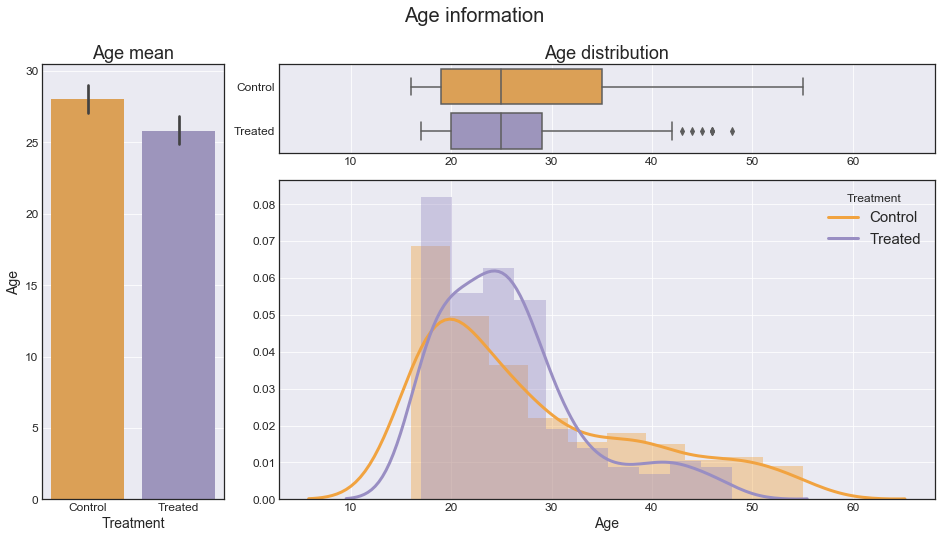

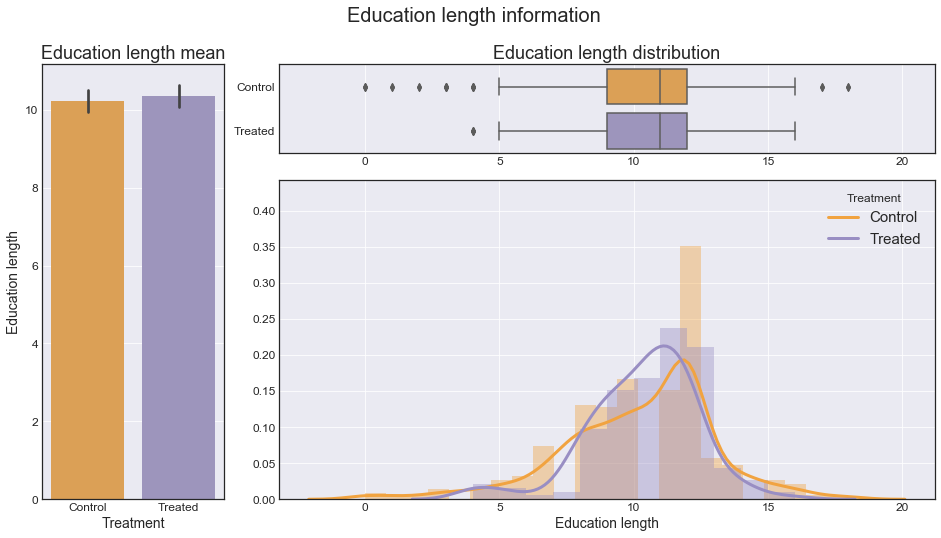

In [10]:
show_multi_var_stats(df = job_training_cat,
                     split_var = 'Treatment',
                     cols = ['Age', 'Education length'])

As can be observed from the graphs people in the control group seem to cover more diverse age intervals, whereas only a few outliers in the treated group are over 45 years old. Both groups have the means of age variable between 25 and 30 years old which is expected as most of the selected candidates in both groups are relatively young, around 20 or 30 years old.

The years of education feature seems to have almost identical statistical properties in the two groups, with only a few more outliers in the control group. The distributions vary in some parts and there is a very large amount of the control group members with the education length of 12-13 years. The last part can be explained by the fact that most of the traditional education cycles in normal circumstances last for that long.

We then plotted the categorical features of the dataset: *Marital status*, *Degree status* and *Ethnicity* again split by the values in the column Treatment.

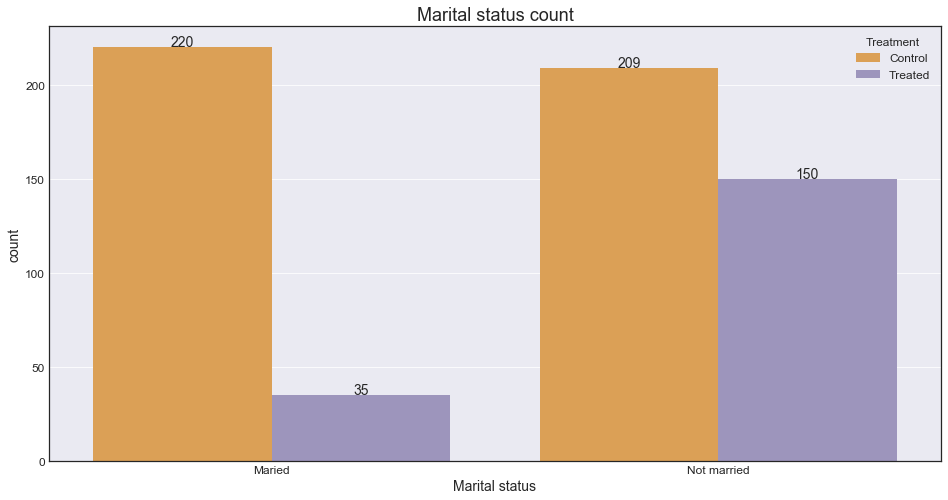

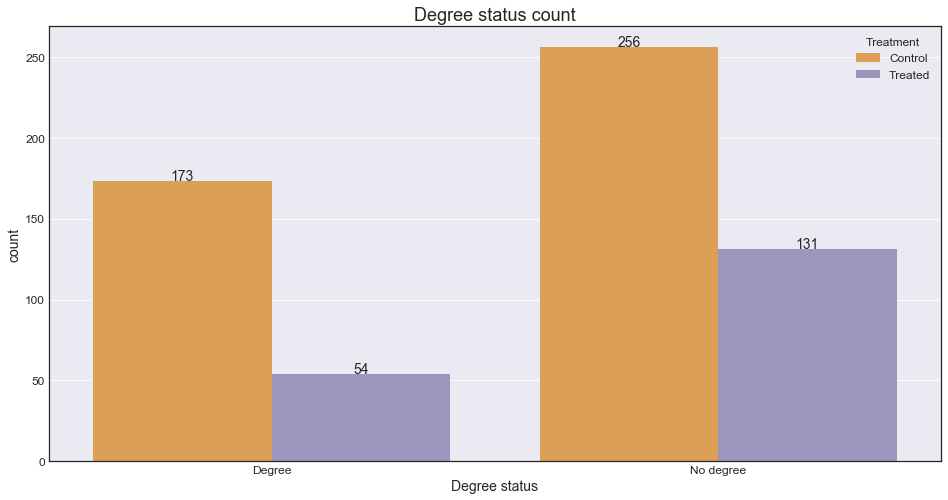

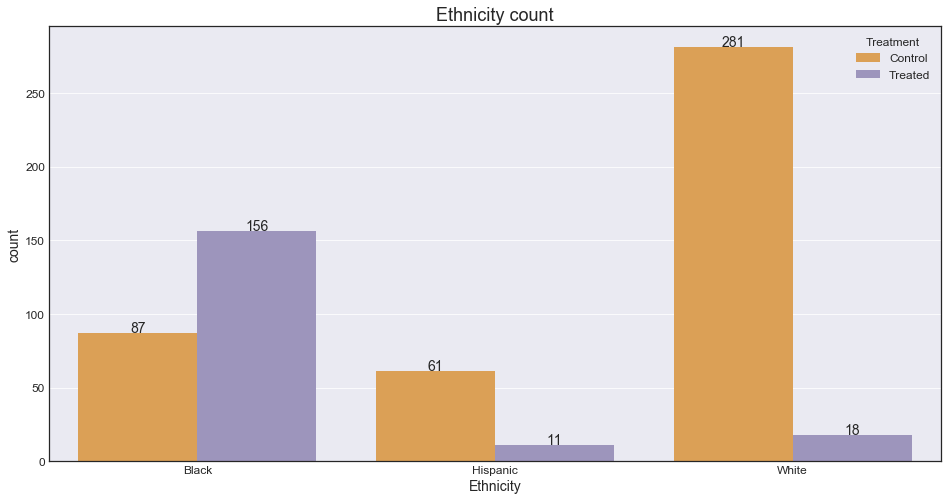

In [11]:
show_multi_var_count(df = job_training_cat,
                     split_var = 'Treatment',
                     cols = ['Marital status', 'Degree status', 'Ethnicity'])

As we have previously seen the number of group members is significantly larger in the control group, and it is again demonstrated in these count plots.

The number of married and unmarried people in the control group is almost even, while the number of married people in the treated group is more than 4 times smaller than the number of unmarried people, with only 35 married participants out of total 185.

In both groups there is a larger amount of people with no degree, than the amount of ones with a formal degree.

The ethnicities are pretty unevenly spread among the control and treatment group. The control group contains mostly white people, followed by black and hispanic people, while the treatment group consists mostly of black people, followed in much lesser amount by the white and hispanic people.

In the end of this part, we tried to illustrate the change in the incomes of the people in the both groups across the years by visualising continuous features *1974 income*, *1975 income* and the outcome feature *1978 income*.

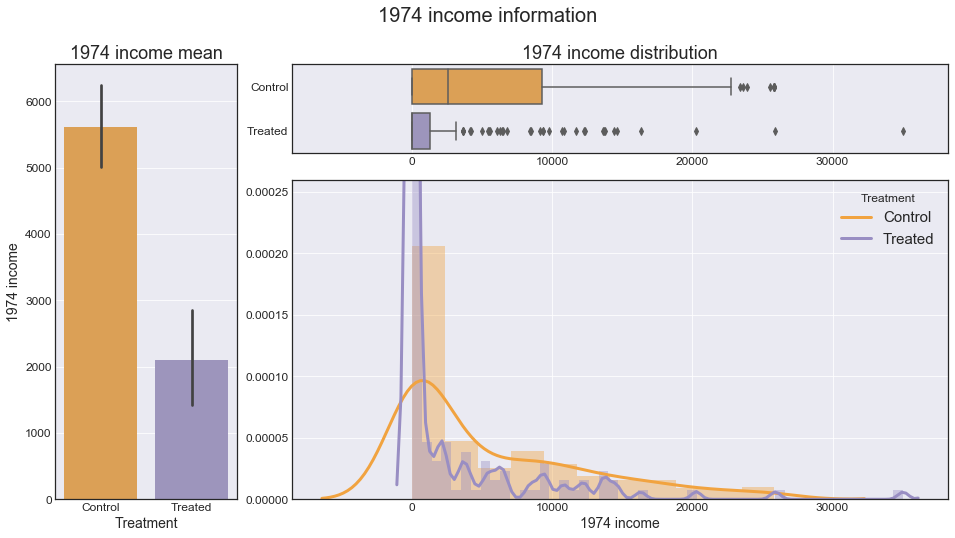

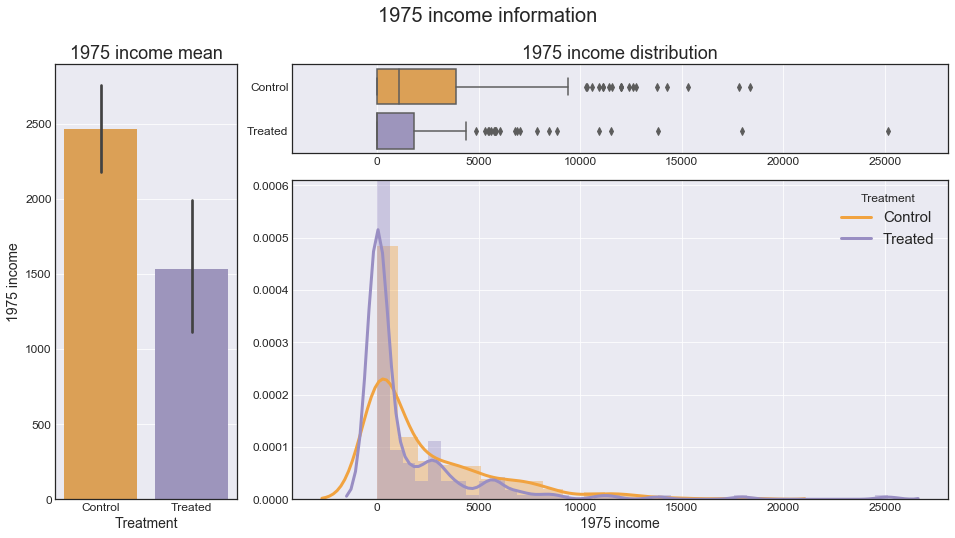

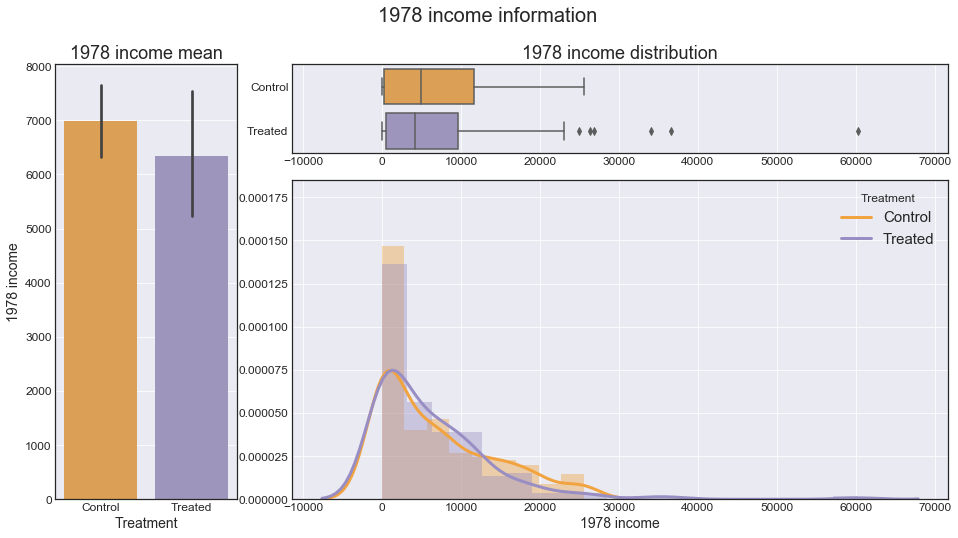

In [12]:
show_multi_var_stats(df = job_training_cat,
                     split_var = 'Treatment',
                     cols = ['1974 income', '1975 income', '1978 income'])

It is noticeable that the income of the control group in both 1974 and 1975 is mostly larger than the income for the same years in the treated group. Significant percentage of both groups has extremely low relative income, which means that most of them are either unemployed or volunteering instead of working for a steady paycheck. It can also be observed that the mean incomes in the groups are first downgraded in the 1975 comparing to their incomes in 1974, with the mean income of the control group lowering for almost 3000 payment units. Afterwards we can see that the trend has been changed, and that both groups show steady growth in their incomes in the period from 1975 to 1978.

In the end, we can say that although the difference between outcomes of both groups in 1978 has been declared insignificant by the naive "researcher" in the superficial analysis, created graphs show that the amount of unemployed people in the treated group has been greatly reduced and in the year 1978 even got lower than the same amount in the control group. It is also important to add, that in previous years only the rare outliers of the treated group had incomes larger than 5000 units, but in 1978 that number has considerably improved.

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

## Solution 3.

Logistic regression represents a type of regression model that is particularly useful for the predictive analysis when the dependent variable is dichotomous (binary). Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables. More information about logistic regression can be found on the [link.](http://www.statisticssolutions.com/what-is-logistic-regression/)

In our case, the idea is to use logistical regression in order to obtain propensity scores for the *Treatment* variable. The binary/dependent variable in this dataset is the *treat* feature of the original *job_training* DataFrame. The independent variables are stored in the same DataFrame, but we decided to drop the *treat* feature (because it is the one we are trying to predict with our model) and the *re78* feature (since it represents the income gained in 1978 a.k.a. outcome variable which contains the data collected after the training was finished). We decided to keep feature *white*, that we created in earlier steps, even though it wasn’t present in the original dataset, because we believe that it has some predictive power that should not be overlooked.

Then we fitted our logistic regression model to the entire dataset according to these variables.

In [13]:
logistic = LogisticRegression()
#assign values to X and y
y=job_training['treat']
#
X=job_training.drop(['re78', 'treat'], axis = 1)
#fit the logistic regression model to entire dataset
logistic.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In order to balance the dataset across treated and control group, we used the function *[predict_proba()](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba)* that returns probability estimates for each of the selected subjects.

In [14]:
#estimate propensity scores
pred = logistic.predict_proba(X)
pred

array([[ 0.48723672,  0.51276328],
       [ 0.7061392 ,  0.2938608 ],
       [ 0.35144998,  0.64855002],
       ..., 
       [ 0.88237872,  0.11762128],
       [ 0.4383438 ,  0.5616562 ],
       [ 0.84972247,  0.15027753]])

First number in each array element represents the probability that the subject has been a part of the control group, while the second number represents the probability that he/she was in the treated group.  The number of elements of the array is the same as the number of rows in the *job_training* DataFrame, as each of those elements gives us the probabilities for one particular subject.

After we calculated the propensity scores we created the *propensity_df* DataFrame which contains:

 * the *id* feature that is used for nomination and recognition of each subject and as the index of the Dataframe,
 * second value of each element  in the propensity scores array, which represents the *Probability of being treated* for each subject (We decided to keep only one this value because the value of the *Probability of not being treated* can be calculated quite easily by the equation 1-*Probability of being treated*),
 * the *Treatment* categorical feature created for each subject in the *job_training_cat* DataFrame which represents the real information about whether or not the selected subject took part in the educational training,
 * the * Ethnicity* categorical feature created for each subject in the *job_training_cat* DataFrame whose usage will be explained in detail in the Task 1.5.
 
This DataFrame will be much more convenient to use in the later steps of the analysis.

In [15]:
#create dataframe with propensity and treatment
propensity_df = pd.DataFrame(pred[:,1])
propensity_df.columns = ['Probability of being treated']
propensity_df = propensity_df.set_index(job_training_cat.index)
propensity_df['Treatment'] = job_training_cat['Treatment']
#added because of Task 1.5.
propensity_df['Ethnicity'] = job_training_cat['Ethnicity']
propensity_df.head()

,Probability of being treated,Treatment,Ethnicity
id,,,
NSW1,0.512763,Treated,Black
NSW2,0.293861,Treated,Hispanic
NSW3,0.648550,Treated,Black
NSW4,0.667477,Treated,Black
NSW5,0.663504,Treated,Black


In order to check the overall successfulness of our estimations we used the *[predict()](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict)* function to create an array with predicted values of the *Treatment* feature for each subject.

In [16]:
y_pred = logistic.predict(X)

Then we created the confusion matrix which will help us estimate the accuracy of the classification done in previous steps.  Because *[confusion_matrix()](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)* from *sklearn* library returns an array, we visualized the obtained results with a heat map.

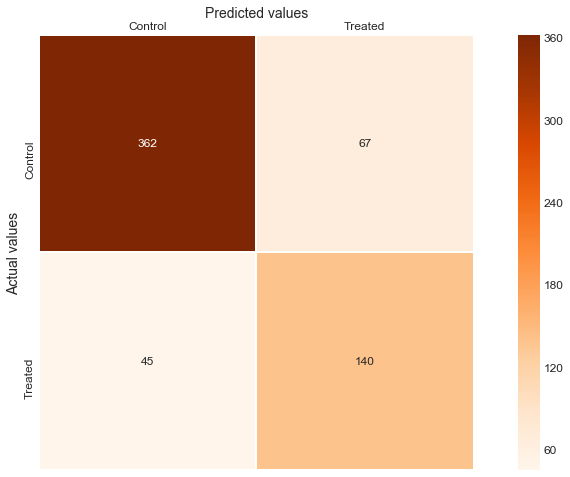

In [17]:
#sns.set(font_scale=1.4)#for label size
ax = sns.heatmap(confusion_matrix(y, y_pred), square = True, annot = True, fmt = 'd', linewidths = '1', cmap = 'Oranges',
            xticklabels = ['Control', 'Treated'], yticklabels = ['Control', 'Treated'])
ax.get_xaxis().set_label_position('top')
ax.get_xaxis().set_ticks_position('top')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')

The heat map shows that out classification mechanism is mostly correct. There is 362 members of the control group that are correctly classified as not being treated (true negatives), while 67 members of the control group have been classified as treated and they were not (false positives). There are also 45 members of the treated group that were classified as the members of the control group (false negatives), and 140 members of the treated group that were classified correctly (true positives).

We also used the function *[classification_report()](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)* from *sklearn* library to generate textual summary of the precision, recall and F1 score for each group.

In [18]:
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       0.89      0.84      0.87       429
          1       0.68      0.76      0.71       185

avg / total       0.83      0.82      0.82       614



In the classification report we can see that all of the calculated metrics have satisfactory values. While all of the indicators are lower in the treated group, the average values across both groups are all above 0.8 which is enough for the cases in our analysis.

More information about each of these indicators can be found on the [link](https://en.wikipedia.org/wiki/Precision_and_recall).

## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

## Solution 4.

In order to balance the dataset via matching we can represent each person as a node in a graph. The weight of the edges between these nodes represent the *similarity* between each of the subjects. This similarity is defined as the difference of the propensity scores. This graph is actually bipartite, as it will contain edges that connect only nodes that correspond to people from different groups (*Treated* or *Control*).

In order to manipulate our graph, we used the [networkx package](https://networkx.github.io/documentation/latest/). We used methods [add_nodes_from()](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.Graph.add_nodes_from.html) to create the nodes and [add_edge()](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.DiGraph.add_edge.html) weighted to add the edge to the graph. 

In [19]:
matching_graph = nx.Graph()
matching_graph.add_nodes_from(propensity_df.index)

In order to fill the graph with edges we have to connect every person from the *Treated* group with every person from the *Control* group. For every *Treated*-*Control* pair we add an edge that represents the *similarity* between that pair.

In [20]:
#add an edge between every treated-control pair
for treated_id, treated_row in propensity_df[propensity_df['Treatment'] == 'Treated'].iterrows():
    for untreated_id, untreated_row in propensity_df[propensity_df['Treatment'] == 'Control'].iterrows():
        #compute the weight as 1 - the absolute difference of treatment probabilities
        matching_graph.add_edge(treated_id,
                                untreated_id,
                                weight = 1 - np.abs(treated_row['Probability of being treated'] - untreated_row['Probability of being treated']))

After adding the edges, we have to select the most similar pairs. That can be done with the [max_weight_matching()](https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.algorithms.matching.max_weight_matching.html) function which selects a subset of edges with highest weight in which no node occurs more than once.

In [21]:
matched_edges = nx.max_weight_matching(matching_graph, maxcardinality = True)

Finally, from the obtained *matched_edges*, we create a *matched_subjects* DataFrame which is a subset of the *job_training_cat* DataFrame that contains only the most similar test subjects. The information about selected subjects is collected from the *job_training_cat* DataFrame where they are more adapted for visual representations.

In [22]:
matched_subjects = job_training_cat[job_training_cat.index.isin(matched_edges)]
len(matched_subjects)

370

As we can see there are 370 subjects in total in the *matched_subjects* DataFrame collected from both control and treated group.

Afterwards, we compared the distributions of features in the control and treated group, but only for the subjects that were matched. We started off by comparing continuous variables *Age* and *Education length*.

<a id='task-4-plots'/>

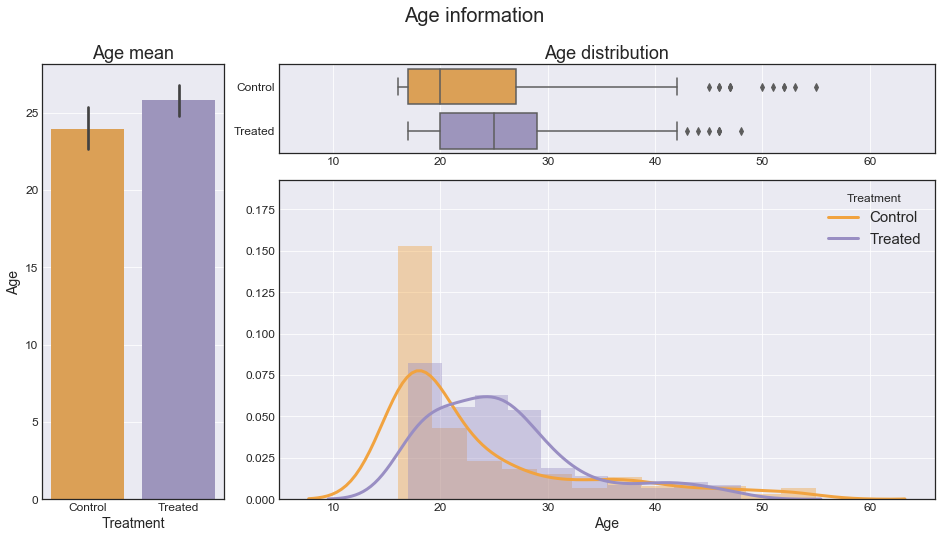

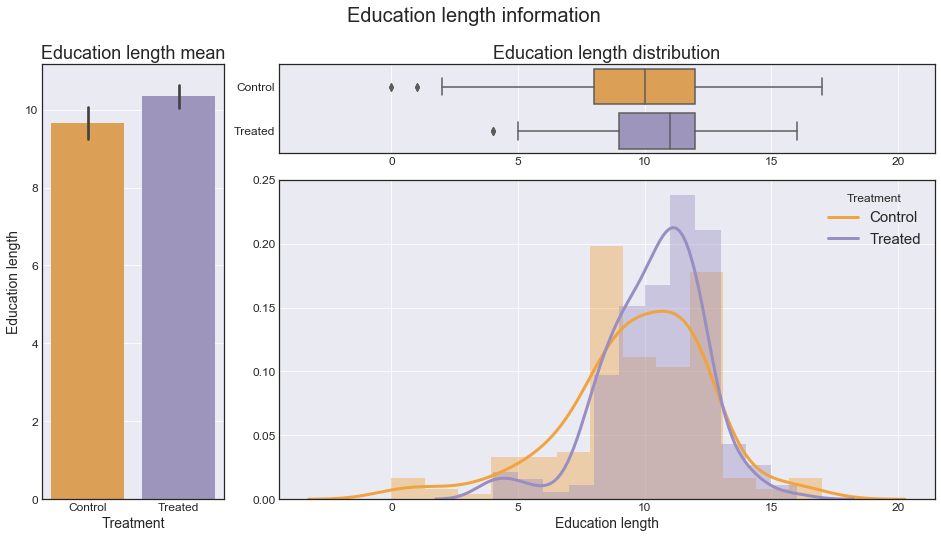

In [23]:
show_multi_var_stats(df = matched_subjects,
                     split_var = 'Treatment',
                     cols = ['Age', 'Education length'])

The distributions of these features seem to have multiple similar traits. In both groups there are more of the younger subjects, and subjects older than 43 years appear only as outliers. The mean of the *Age* feature seems to be slightly larger in the treated group, but both means are close to the age of 25. Regarding the *Education length* feature, the means are again similar but this time the distribution is showing the larger amount of people from the control group with 8 years of formal education, while the treated subjects still mostly have 12 years of formal education.

We illustrated the categorical features of the matched subjects (*Marital status*, *Degree status* and *Ethnicity*) by count plots like in the previous tasks.

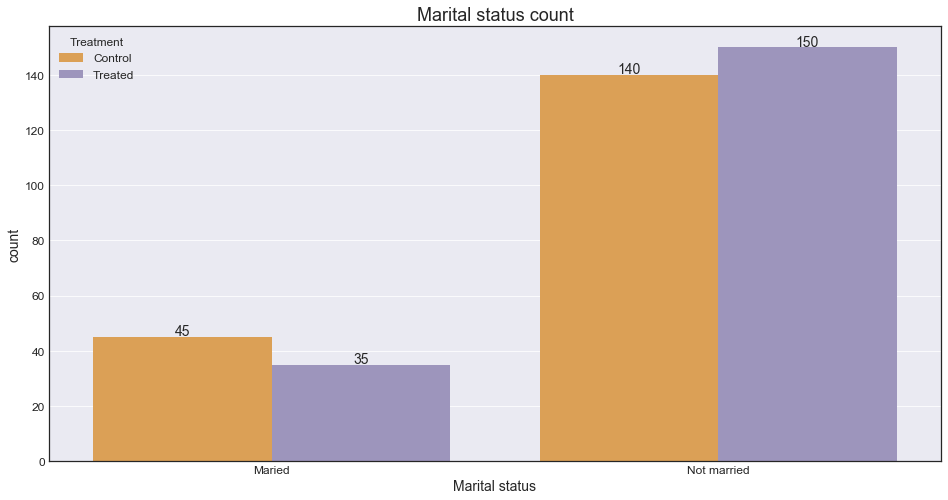

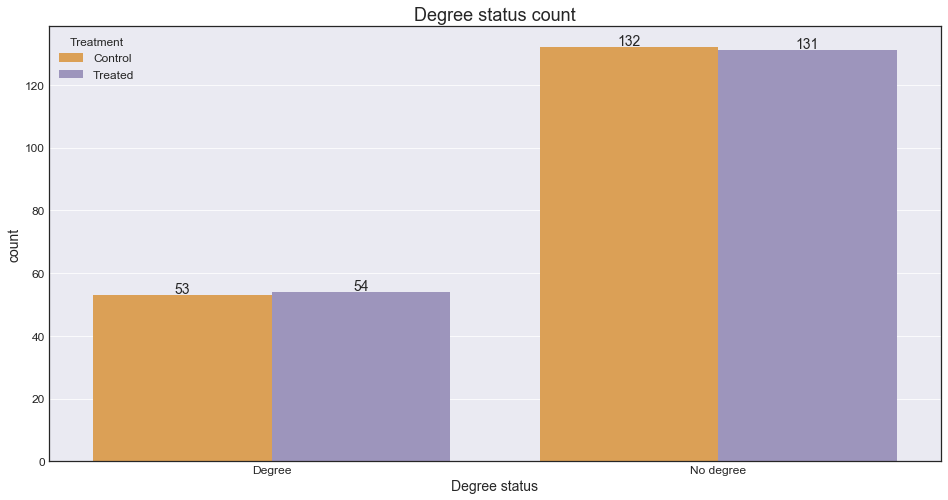

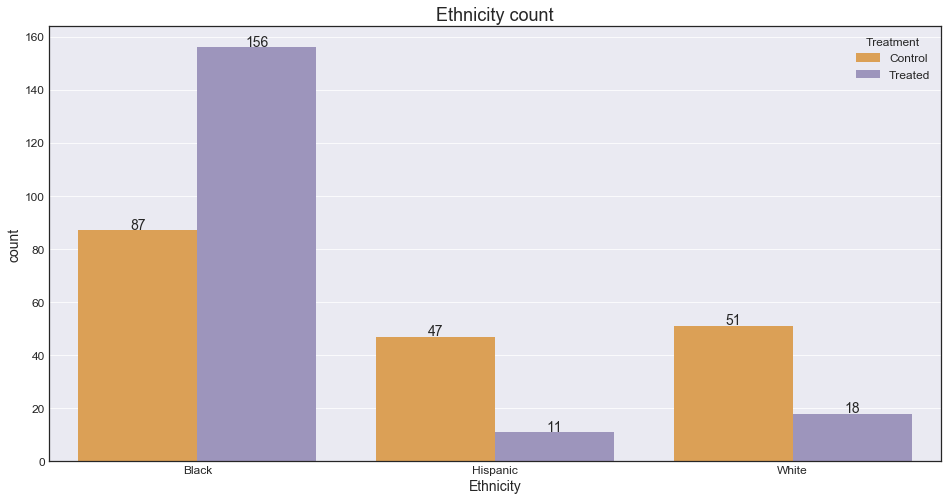

In [24]:
show_multi_var_count(df = matched_subjects,
                     split_var = 'Treatment',
                     cols = ['Marital status', 'Degree status', 'Ethnicity'])

We can see that the matching process significantly improved the similarity between the control and treated group concerning the categorical features. The only difference for the *Marital status* variable is that the treated group has a slightly smaller number of married subjects – 35. The important thing is that this time the control group has only 10 more married subjects which definitely improved the comparison potential of our model.

The *Degree status* feature differs for only one subject when we are comparing the treated and control group, which makes it practically perfectly split.

The *Ethnicity* variable might have some problematic elements. The number of the black people in the comparison is still exceedingly larger in the treated group, while the control group has a greater amount of Hispanic and white people. This fact might present problem in the final analysis and comparison of groups because they are still very different when compared by the *Ethnicity* feature.

Additionally, we compared the incomes of both groups of matched subjects across the three given years by plotting their means and distributions.

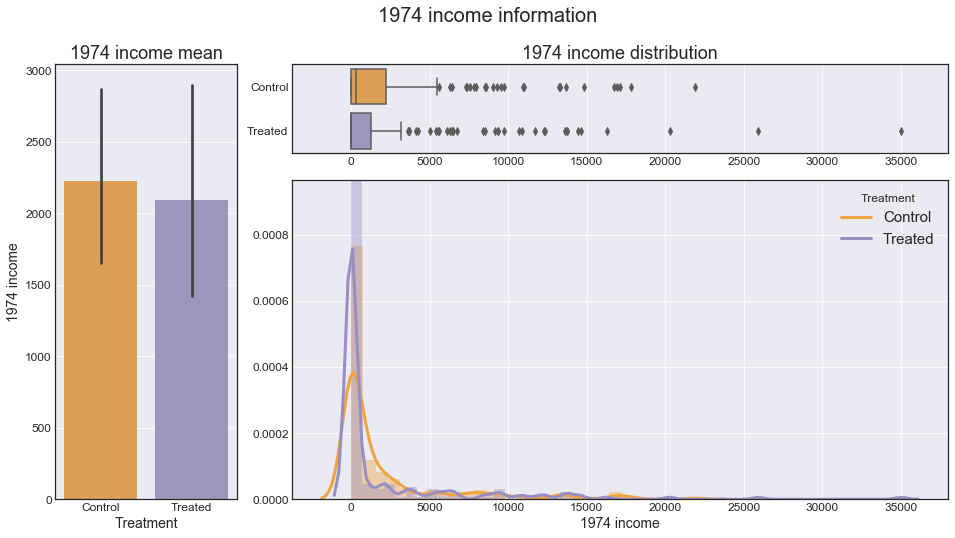

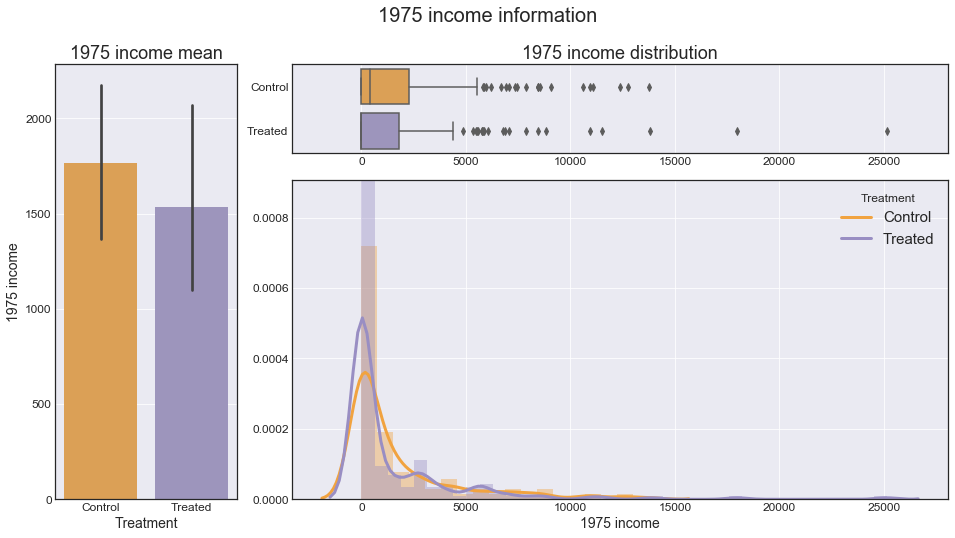

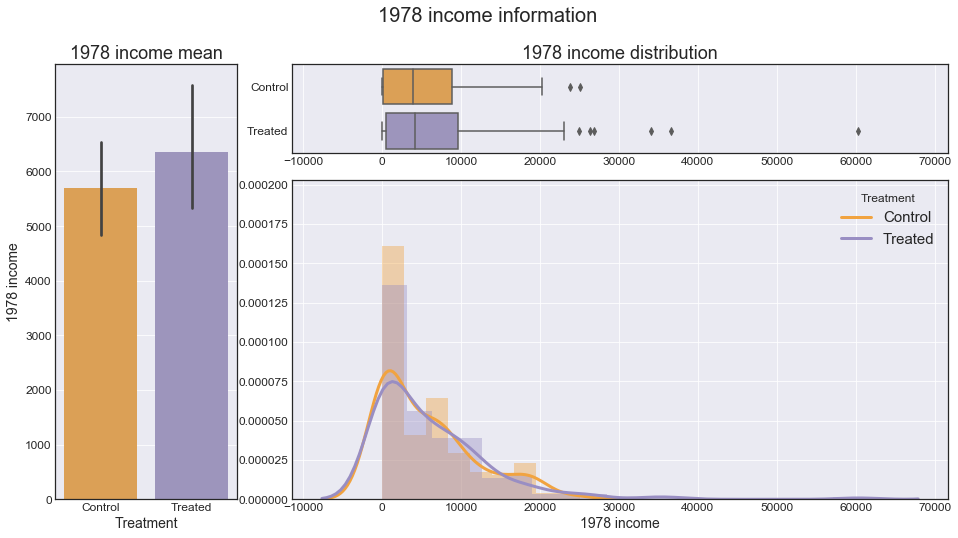

In [25]:
show_multi_var_stats(df = matched_subjects,
                     split_var = 'Treatment',
                     cols = ['1974 income', '1975 income', '1978 income'])

We can observe that the two groups now have more evenly spread subjects in all of the continuous income variables. On the graphs for the *1974 income* variable it can be seen that the mean value of the control group is slightly higher than the mean of the treated group, but the standard error of the mean is large in both groups and there are many outliers in both groups.

Concerning the *1975 income* feature, situation seem similar. The means got slightly smaller than in the previous year, and the number of unemployed or volunteers has decreased, but the standard error of the mean is still large and outliers still numerous.

In the end, when we take a look at the outcome feature *1978 income* we can see that this is the first time that the mean of this feature seems greater in the treated group. We still can’t make any final conclusions because the standard error of the mean is not small enough, but this graph is much more useful for comparisons than the one made as the part of the naive analysis. We can see that according to these distributions, the number of unemployed people in the treated group has significantly dropped comparing to the previous years. The number of outliers has also dropped and the means of both groups have made an important improvement, jumping from average of around 1750 units in 1975 to average of around 6000 units.

For time being, we still cannot make a final decision whether the treated group really had a larger outcome variable or not, but we can say that the program did help reduce the number of unemployed subjects in this group which is also significant.

## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

## Solution 5.

From [plots](#task-4-plots) in the previous task we can see that all of the categorical variables have been pretty nicely matched except for *Ethnicity*.

That could pose a problem for our analysis as the black population in the United States of America has been [historically underrepresented](https://en.wikipedia.org/wiki/Racial_wage_gap_in_the_United_States) among higer-paid jobs which would potentially influence our results and conclusions.

In order to compensate for this, we chose to adjust the balancing between groups by adding the condition that the subjects from the *Treated* and *Control* groups will be connected only if their ethnicities matched.

In [26]:
adjusted_matching_graph = nx.Graph()
adjusted_matching_graph.add_nodes_from(propensity_df.index)

for treated_id, treated_row in propensity_df[propensity_df['Treatment'] == 'Treated'].iterrows():
    for untreated_id, untreated_row in propensity_df[propensity_df['Treatment'] == 'Control'].iterrows():
        #add an edge only if ethnicities are the same
        if untreated_row['Ethnicity'] == treated_row['Ethnicity']:
            adjusted_matching_graph.add_edge(treated_id,
                                             untreated_id,
                                             weight = 1 - np.abs(treated_row['Probability of being treated'] - untreated_row['Probability of being treated']))

The following steps to obtain a subset with the most similar subjects is the same as in Task 1.4.

In [27]:
adjusted_matched_edges = nx.max_weight_matching(adjusted_matching_graph, maxcardinality = True)
adjusted_matched_subjects = job_training_cat[job_training_cat.index.isin(adjusted_matched_edges)]
len(adjusted_matched_subjects)

232

We can see that by adding the *Ethnicity* constraint to matching we obtained less subjects. That is becuse the *Control* group contains only 87 black persons, and the *Treated* group has 156 of them. That means that we cannot match all of the subjects from the *Treated* group with the subjects from the *Control* group.

There are 69 more black people in the *Treated* group than in *Control*, which is exactly double the difference between the number of matched subjects from Task 1.4 and the number of newly matched subjects in this task (It's double because if we exclude one person from the *Treated* group, we also have to exclude a person from the *Control* group).

Now, we can plot the new distributions of all variables:

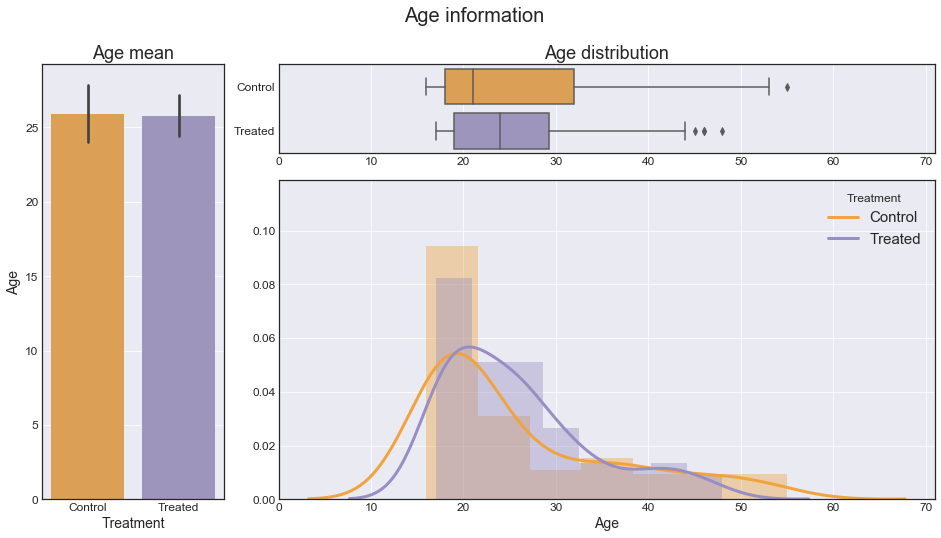

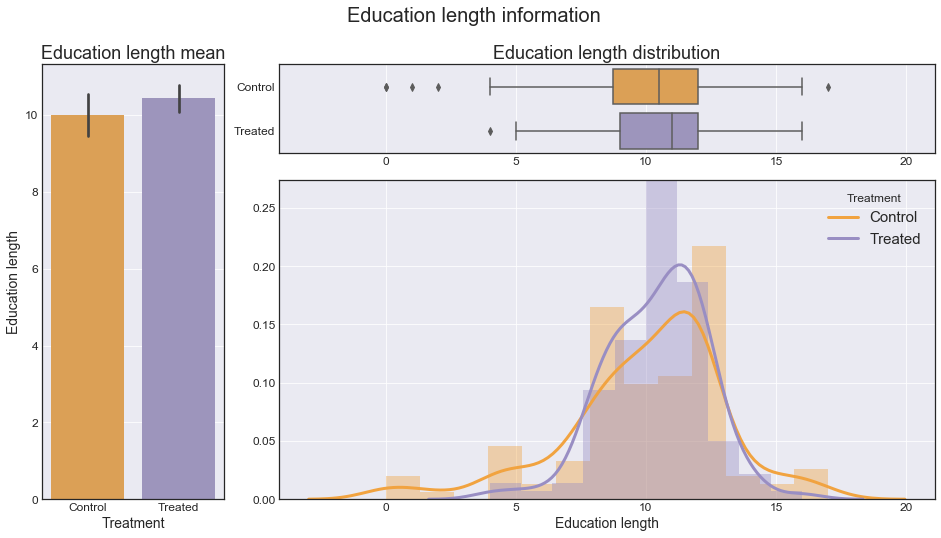

In [28]:
show_multi_var_stats(df = adjusted_matched_subjects,
                     split_var = 'Treatment',
                     cols = ['Age', 'Education length'])

We can see that compared to the distributions from the previous task, the *Age* and *Education length* variables have been balanced even better. Previously, the mean age for the *Control* group was around 24 and for the *Treated* was around 26, whereas now the mean age is around 26 for both groups. The mean education length has improved as well. Previously, we had a mean of around 9 years in the *Control* and 11 in the *Treated* group, and now it's around 10 in the *Control* group and 11 in the *Treated*.

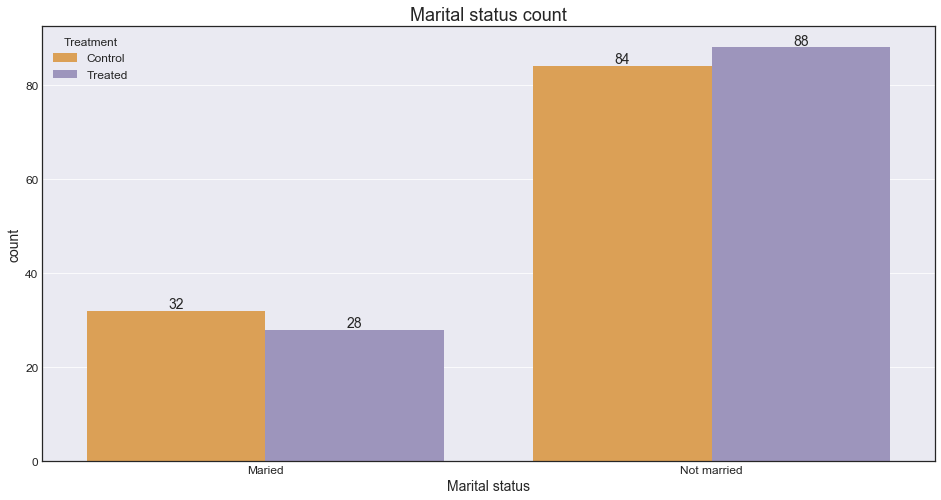

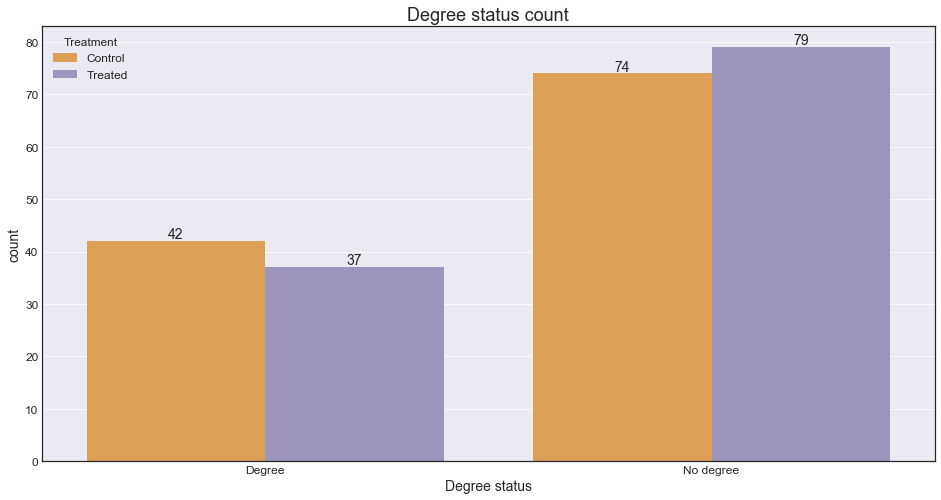

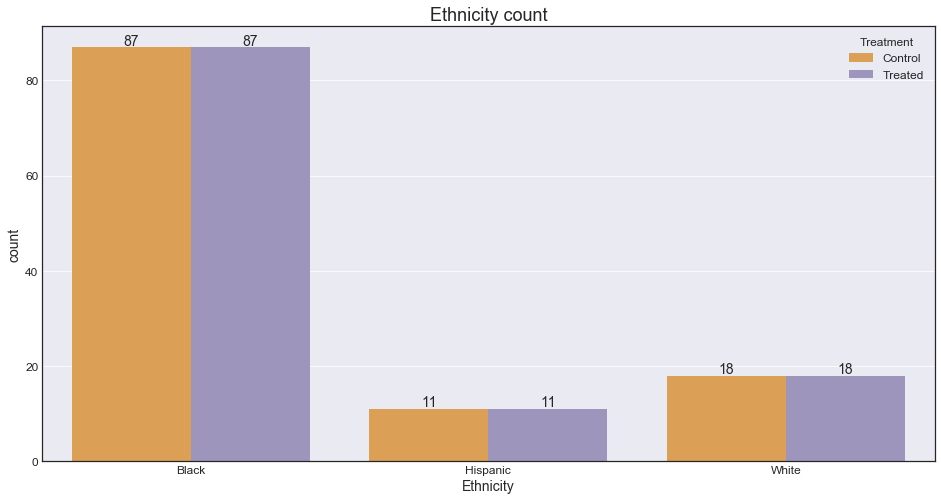

In [29]:
show_multi_var_count(df = adjusted_matched_subjects,
                     split_var = 'Treatment',
                     cols = ['Marital status', 'Degree status', 'Ethnicity'])

Here, besides the expected equalization of the groups for *Ethnicity*, we can see that the *Marital status* variable improved (difference of 4 between groups compared to 10 previously) slightly and the *Degree status* has worsened slightly (difference of 5 between groups compared to 1 previously), but not enough to significantly impact our analysis.

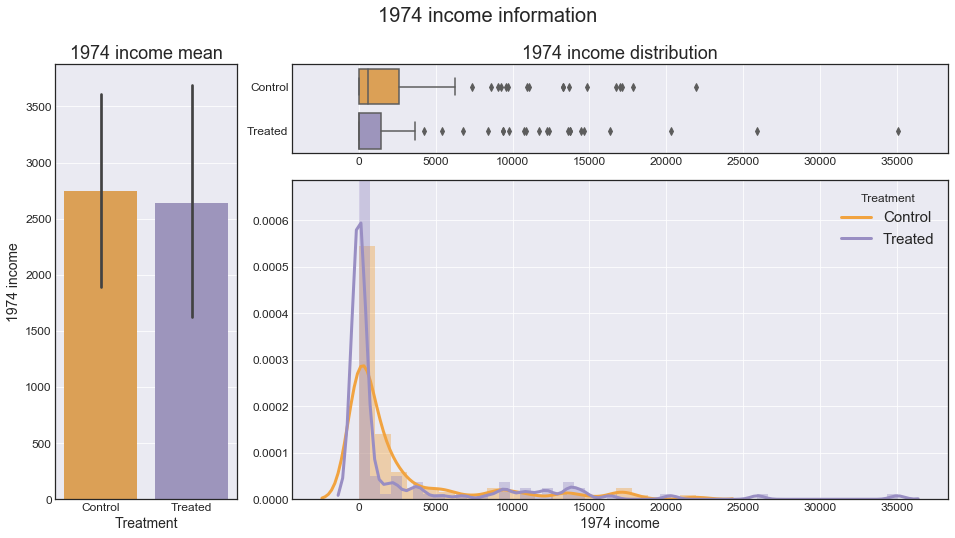

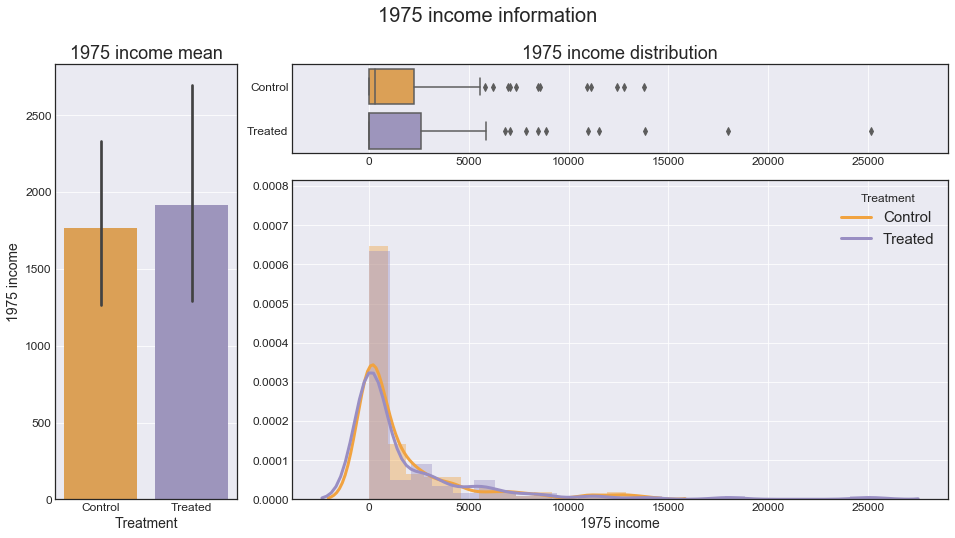

In [30]:
show_multi_var_stats(df = adjusted_matched_subjects,
                     split_var = 'Treatment',
                     cols = ['1974 income', '1975 income'])

We can also observe that the mean income for 1974 has remained similar between groups. However the difference of the mean income in 1975 has been reduced slightly. Previously, we had a difference of around 220 USD between the groups and now we have a difference of around 150 USD.

## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?


## Solution 6.

For the visualization of the *1978 income* feature we firstly used the distribution and mean graphs we have created several times in prior steps.

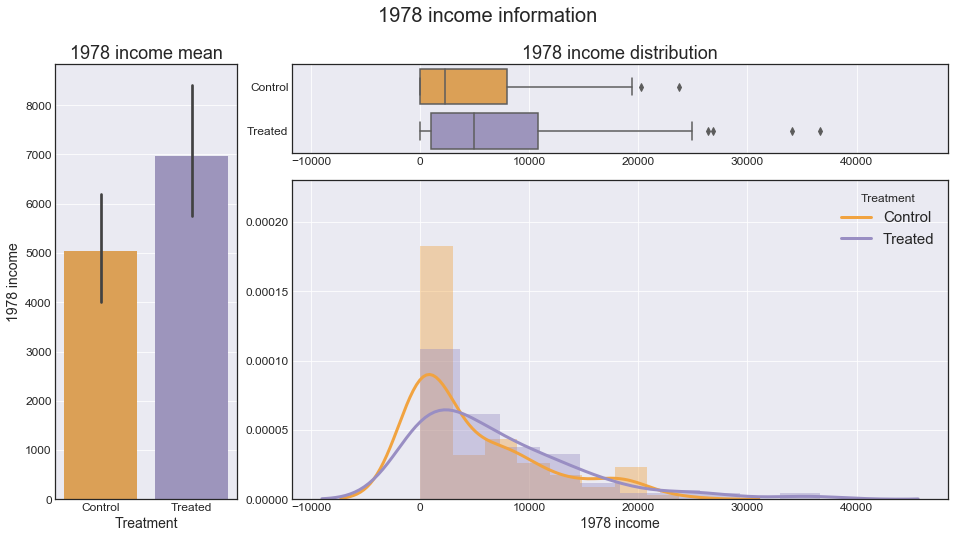

In [31]:
show_stats(df = adjusted_matched_subjects,
              split_var = 'Treatment',
              col = '1978 income')

When we finally compare the outcome - *1978 income* feature across the treated and control group in the *adjusted_matched_subjects* DataFrame we can see that there exists an important improvement among subjects that were a part of the educational training, comparing to the subjects from the control group. The mean of the treated group increased after the treatment to around 7000 units, while the mean of the control group was around juts 5000 units. The interquartile range of the treated group has shifted and this is the first visualization where its lower boundary isn’t zero. This can’t be said about the same range of the control group. The amount of unemployed or volunteering people in the control group is still visibly greater than the same number in the treated group.

We wanted to make the results of our analysis even easier to interpret so we created some additional visualizations of the outcome feature. We first wanted to plot the so-called lollipop graph which shows the difference in the outcome for each of the matched pairs.

In order to create this graph we firstly created a new DataFrame from the dictionary containing all of the pairs of matched subjects, after the adjustments. We then removed half of the pairs, because the dictionary contains the values for oriented edges, which means that each pair would occur twice once as a pair treated-control and once as a pair control-treated. We then added the exact value of *1978 income* for each subject in each pair of the created *lollipop_df* DataFrame. The values of the income of the treated subjects were stored in the column *1978 income treated*, and the corresponding values of the control subjects were stored in the column *1978 income control*. In the end all of the pairs were sorted by values in the *1978 income control* variable.

In [32]:
#create dataframe
lollipop_df = pd.DataFrame.from_dict(adjusted_matched_edges, orient = 'index')
#remove duplicats
lollipop_df = lollipop_df[lollipop_df.index.str.contains("PSID") == False]
#set column names
lollipop_df.index.name = 'Treated'
lollipop_df.columns = ['Control']
#collect data about treated subject in a pair
lollipop_df['1978 income treated'] = job_training_cat[job_training_cat.index.isin(lollipop_df.index)]['1978 income']
#collect data about control subject in a pair
ps_income = job_training_cat[job_training_cat.index.isin(lollipop_df['Control'])]['1978 income']
lollipop_df = pd.merge(lollipop_df.reset_index(), ps_income.reset_index(), left_on=['Control'], right_on=['id'], how='inner').set_index('Treated')
lollipop_df.drop('id', axis = 1, inplace = True)
#rename new column
lollipop_df.rename(columns = {'1978 income': '1978 income control'}, inplace = True)
#sort values
lollipop_df.sort_values(by = '1978 income control', ascending = False, inplace = True)

We then created the vertical plot using *hlines()* function  to represent the differences between pairs, and added scatter points that represent values of *1978 income* for  treated and control subject in each pair.

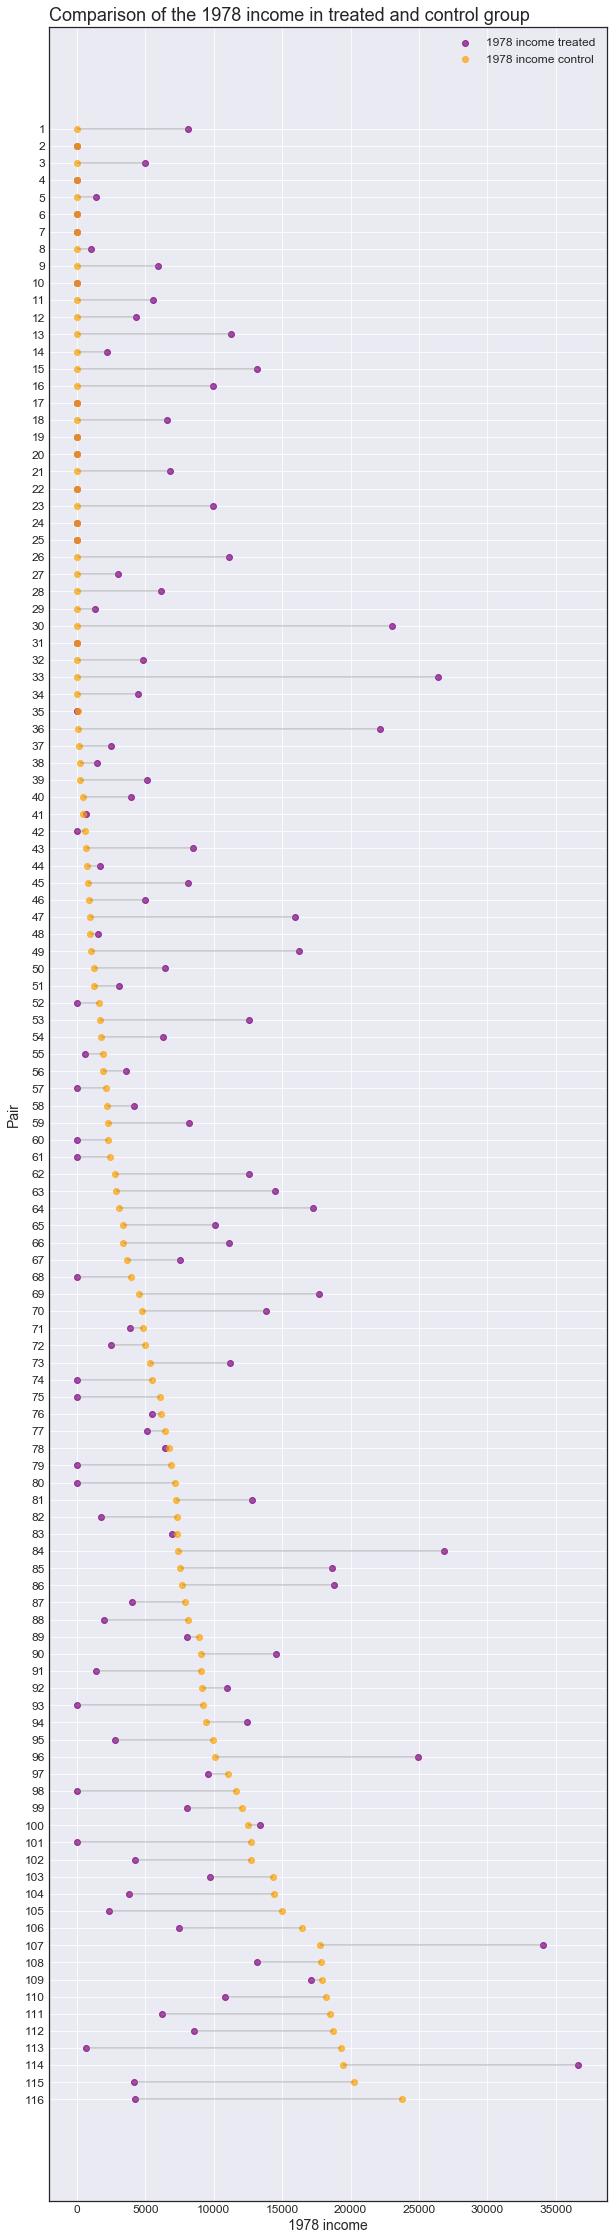

In [33]:
#reset index so the pair number can be printed instead
lollipop_df = lollipop_df.reset_index()
pair_range = range(1, len(lollipop_df.index) + 1)
 
# The vertical plot is made using the hline function
plt.figure(figsize=(10,40))
plt.hlines(y = pair_range, xmin = lollipop_df['1978 income treated'],xmax = lollipop_df['1978 income control'],
           color = 'grey', alpha = 0.4)
plt.scatter(lollipop_df['1978 income treated'], pair_range, color='purple', alpha=0.7, label='1978 income treated')
plt.scatter(lollipop_df['1978 income control'], pair_range, color='orange', alpha=0.7 , label='1978 income control')
plt.legend()
 
# Add title and axis names
plt.yticks(pair_range[::-1], lollipop_df.index+1)
plt.title("Comparison of the 1978 income in treated and control group", loc='left')
plt.xlabel('1978 income')
plt.ylabel('Pair')

This graph illustrates the differences of the income of the paired subjects, that were assessed as similar during the adjusted matching. Not very large number of pairs has same, or even similar, values of the final outcome variable, which means that subjects were very much alike considering their background features ended up having different incomes in 1978. We can also observe that in the larger number of pairs the subject that was a part of the education training program ended up having higher income.

In the end, we wanted to create a graph that shows the flow of the income across the observed years for both treated and control group subjects from out final *adjusted_matched_subjects* DataFrame. We used the melt function to reorganize our DataFrame in order to make or plotting easier and stored it to the *melted_df* DataFrame. We then created a pointplot which will represent the mean values of the income in each of the groups across the observed years.

(0, 8696.6048177241373)

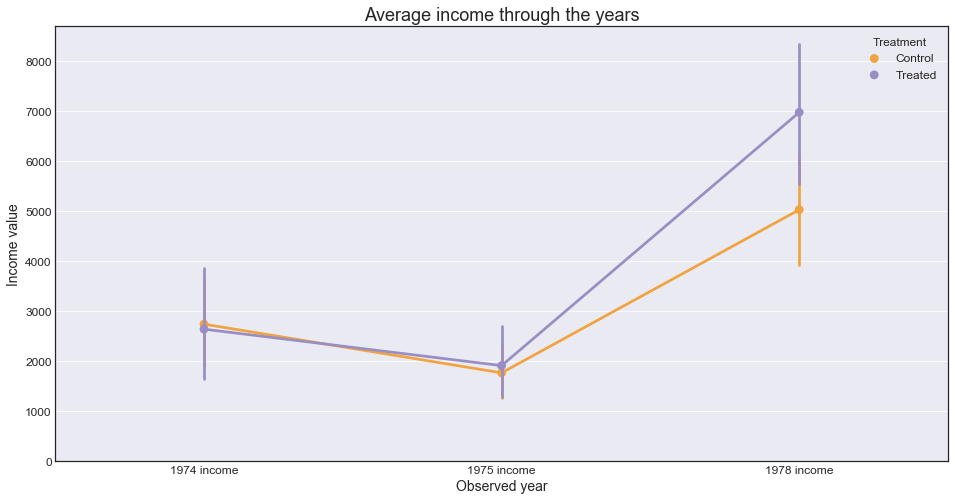

In [34]:
#reorganize the dataframe for easier plotting
melted_df = pd.melt(adjusted_matched_subjects,
                    id_vars = ['Treatment'],
                    value_vars = ['1974 income', '1975 income', '1978 income'],
                    var_name = 'Observed year',
                    value_name = 'Income value')

#create a pointplot to show average income through the years
ax = sns.pointplot(x = 'Observed year', y = 'Income value', hue = 'Treatment',
                   hue_order = ['Control', 'Treated'], data = melted_df)
ax.set_title('Average income through the years')
ax.set_ylim(bottom = 0)

This final graph best illustrates our last conclusion, that there is an observable and significant advancement in the incomes of the treated group after the training program. While the differences between the means in the years 1974 and 1975 were barely observable, the difference in 1978 is significantly larger between the two groups. We can now gladly deduce that the **job training program was very effective** and that the treated subjects show significant improvement comparing to the control subjects.


## Question 2: Applied ML

 We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).


2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.



## Question 2 Solution

In [40]:
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from time import time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

We first loaded the 20 news groups dataset. This dataset is made up of around 18000 newsgroups posts on 20 topics. This is then split into one subset for training (or development) and one for testing (or for performance evaluation). Since the goal of this assignment is to implement a complete Machine Learning pipeline and since real word datasets are rarely (if ever) split into training/testing parts, we extracted all of the data by setting the parameter value for *subset* to  ‘all’ to get data from both subsets, with shuffled ordering.

In [37]:
newsgroups_all = fetch_20newsgroups(subset='all')

Next, we computed TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

TF-IDF is short for term frequency–inverse document frequency, it is a numerical statistic that gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire document collection (IDF).
The TF-IDF value increases proportionally to the number of times a word appears in the document, but is often offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general. 

In [38]:
tfidf_features = TfidfVectorizer()
vectors = tfidf_features.fit_transform(newsgroups_all.data)

The data that will be later split into train, test and validation is now extracted. *X* contains a Tf-idf-weighted document-term matrix that will be out input for further manipulations, *y* contains the target attribute of the 20 news groups dataset which is the integer index of the categories, and *target_names* contains a list of the categories, with their full names.

In [39]:
X = vectors
y = newsgroups_all.target
target_names = newsgroups_all.target_names

In the following code we used the [sklearn.model_selection.train_test_split()](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to split the data into a test subset, containing 10% of the original data, and a larger subset. Because we chose to use cross-validation as a way to detect the best possible random forest predictor, this larger dataset, containing 90% of the original data is not split at this time. It will be divided into the validation and test subsets during cross-validation.

Since we are going to be training our model on the train data, but ultimately want to be able to classify the test data as accurately as is possible, we need these two datasets to have the same class distributions. If the class distributions are varying we run the risk of introducing a sampling bias.  
Because we wanted our test dataset to have the same distribution across all classes as the train dataset, we set the *stratify* parameter to *y*, the vector containing the different classes for each point in the input data. 
Stratified sampling allows us to extract a dataset in which every class from the original dataset is represented. This is not done randomly, but in a way that makes sure that each class has 10% of its entries in the test dataset. 

In [43]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.1, random_state = 1, stratify = y)

To visualize this we decided to plot the distribution of classes in the *y_test* and *y_train_val* vectors. The orange color represents the train and validations labels, and the purple represents the test labels.

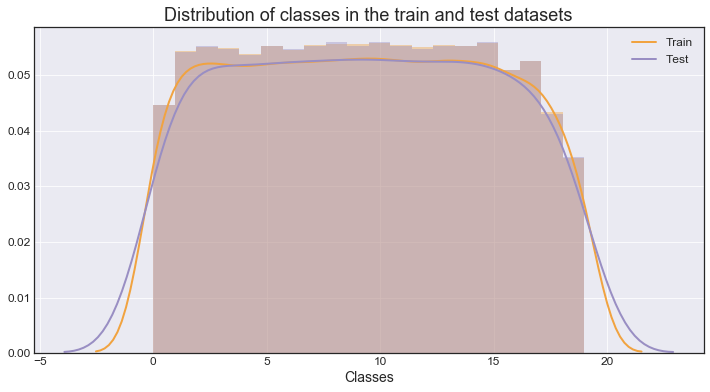

In [44]:
fig, ax = plt.subplots(1, figsize=(12, 6))
sns.distplot(y_train_val, bins=20, kde_kws = {'lw': 2, 'label': 'Train'})
sns.distplot(y_test, bins=20, kde_kws = {'lw': 2, 'label': 'Test'})
ax.set_title('Distribution of classes in the train and test datasets', size = 18)
plt.xlabel('Classes')
plt.show()

As can be seen from the plot above, the distributions are very similar and overlap almost perfectly, confirming that the usage of *sklearn.model_selection.train_test_split()* in the stratified mode achieved even distributions of classes across the datasets.

Extraction of the validation set that represents 10% of the original dataset is achieved through cross-validation. The cross-validation splitting strategy that we have selected is implemented with the [sklearn.model_selection.StratifiedKFold()](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) function. We have used this function to create a stratified K-Folds cross-validator that is later used to split our training and validation into 9 folds. By splitting this dataset into 9 folds we split the 20 news groups dataset into a training, a testing and a validation set (10% for validation and 10% for testing), as was specified in the assignment. Since this is a stratified function, the folds are made by preserving the percentage of samples for each class.

In [45]:
skf = StratifiedKFold(n_splits = 9, shuffle = True, random_state = 1)

In order to predict the labels in the test dataset we trained a [sklearn.ensemble.RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) predictor.

Since the assignment stated that we needed to fine-tune the parameters of our predictor on our validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth", as opposed to simply guessing the parameters, we decided to use the [sklearn.model_selection.GridSearchCV()](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function for this.

The estimator that we passed to this method is the RandomForestClassifier.
To achieve the best possible results, we opted to use cross-validation with the above defined StratifiedKFold. The scoring method used is the accuracy metric. 
Since the input data is well distributed across all classes, the accuracy metric is ideal for evaluation. The accuracy metric returns the fraction of correct predictions. To be more specific, it returns the fraction of labels that match between the predicted and actual labels. We also parallelized the training using 4 threads, by setting the *n_jobs* parameter to 4, and also set the *pre_dispatch* parameter to 4 in order to control the number of jobs that can be dispatched during parallel execution. This is set to avoid an explosion of memory consumption when more jobs get dispatched than CPUs can process.

For the grid search itself, we picked the following ranges for the parameters:
 * n_estimators: 100, 300, 500, 700
 * max_depth: 20, 50

In [46]:
rclf = RandomForestClassifier()
param_grid = { "n_estimators"      : np.arange(100, 800, 200),
               "max_depth"         : np.arange(20, 80, 30)}
grid_search = GridSearchCV(rclf, param_grid, cv = skf, n_jobs  = 4, pre_dispatch = 4, scoring = 'accuracy')
grid_search.fit(X_train_val, y_train_val)
print(grid_search.best_params_)
results = pd.DataFrame(grid_search.cv_results_)
results

{'max_depth': 50, 'n_estimators': 700}


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split6_test_score,split6_train_score,split7_test_score,split7_train_score,split8_test_score,split8_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,15.688484,0.413655,0.769058,0.886556,20,100,"{'max_depth': 20, 'n_estimators': 100}",8,0.761628,0.886057,...,0.768085,0.886214,0.786475,0.890473,0.770789,0.885582,0.440445,0.125307,0.008647,0.004711
1,46.280043,0.917885,0.793349,0.911893,20,300,"{'max_depth': 20, 'n_estimators': 300}",7,0.786998,0.911540,...,0.787766,0.912406,0.804579,0.908705,0.797441,0.913689,0.909084,0.177408,0.007211,0.001564
2,76.730890,1.416432,0.798007,0.916286,20,500,"{'max_depth': 20, 'n_estimators': 500}",6,0.791755,0.917845,...,0.804787,0.917578,0.812034,0.915799,0.795309,0.916208,2.223006,0.120013,0.008034,0.001465
3,100.907167,1.749652,0.800425,0.917826,20,700,"{'max_depth': 20, 'n_estimators': 700}",5,0.793869,0.919437,...,0.801596,0.916650,0.816294,0.918252,0.792644,0.919523,2.722661,0.031598,0.010219,0.001890
4,53.615322,0.295898,0.823949,0.986263,50,100,"{'max_depth': 50, 'n_estimators': 100}",4,0.813953,0.987657,...,0.821809,0.984351,0.837061,0.985215,0.820896,0.987007,1.088532,0.017713,0.006584,0.001045
5,159.191682,0.870983,0.837863,0.989594,50,300,"{'max_depth': 50, 'n_estimators': 300}",3,0.831924,0.989183,...,0.839362,0.989656,0.851970,0.990121,0.832623,0.989393,2.891304,0.041334,0.007816,0.000445
6,264.992638,1.478488,0.841165,0.990043,50,500,"{'max_depth': 50, 'n_estimators': 500}",2,0.838266,0.990046,...,0.829255,0.989391,0.853568,0.990055,0.834222,0.990322,3.478299,0.083023,0.008386,0.000344
7,366.372608,1.953638,0.844349,0.990191,50,700,"{'max_depth': 50, 'n_estimators': 700}",1,0.846195,0.990046,...,0.840426,0.989855,0.851438,0.991050,0.841684,0.989659,15.901971,0.063467,0.003671,0.000482


Above, we have extracted the best hyper-parameters, those that resulted in the highest accuracy score. These parameters are at the very edge of the ones used in the grid search, however due to limited computational resources, and a relatively small increase in accuracy for quite large parameter ranges, we opted to use the best results achieved in this search.
The *results* DataFrame contains many details of each iteration of both the grid search and the cross-validation processes.

The best score can be seen below. It is the best score achieved when predicting the labels on the validation dataset, using the accuracy metric.

In [47]:
print(grid_search.best_score_)
print(grid_search.best_estimator_)

0.844348800189
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=700, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


We can see that the best accuracy obtained during validation is **0.844348800189**.
In order to attain the best possible accuracy when predicting the labels for the test data, we needed to access the best estimator found during the grid search.

*GridSearchCV* is a wrapper over the actual RandomForestClassifier estimator, but the best prediction can be achieved by calling the [predict()](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV.predict) method, either by accessing the attribute *best\_estimator\_* or by simply using the output of the *GridSearchCV* method itself.

In [52]:
y_pred = grid_search.predict(X_test)
score = accuracy_score(y_test, y_pred)
print("accuracy:   %0.5f" % score)

accuracy:   0.85623


The accuracy computed over the test set yields a score of **0.85623**.

In order to better explore these results we built a text report showing the main classification metrics using the [sklearn.metrics.classification_report()](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) function.

In [53]:
print("classification report:")
print(classification_report(y_test, y_pred, target_names = target_names))

classification report:
                          precision    recall  f1-score   support

             alt.atheism       0.92      0.84      0.88        80
           comp.graphics       0.76      0.80      0.78        97
 comp.os.ms-windows.misc       0.81      0.85      0.83        99
comp.sys.ibm.pc.hardware       0.75      0.74      0.75        98
   comp.sys.mac.hardware       0.94      0.84      0.89        96
          comp.windows.x       0.88      0.90      0.89        99
            misc.forsale       0.61      0.91      0.73        98
               rec.autos       0.87      0.85      0.86        99
         rec.motorcycles       0.99      0.92      0.95       100
      rec.sport.baseball       0.95      0.89      0.92        99
        rec.sport.hockey       0.94      0.99      0.97       100
               sci.crypt       0.97      0.94      0.95        99
         sci.electronics       0.79      0.71      0.75        98
                 sci.med       0.92      0.85      0

The report shows the precision, recall, F1-score and support for each class

More information for the precision, recall and f1-score indicators can be found on the following [link](https://en.wikipedia.org/wiki/Precision_and_recall).

The support is the number of occurrences of each class in y_true.

The last line gives a weighted average of precision, recall and f1-score where the weights are the support values. The last line also contains the sum of the support values.
In the classification report we can see that all of the calculated metrics have satisfactory values. The average values across all classes are all above 0.8 which is statisfactory.

The confusion matrix can be used to evaluate the quality of the output of the best RandomForestClassifier on the input data. 

The diagonal elements in the matrix represent the number of points that have been correctly classified, in other words the number of points for which the predicted label is the same as the true label.
Elements that are not on the diagonal are those that have been mislabeled by the classifier.
In an ideal case, the diagonal values would be the same as the number of points in each class. We aim to get the highest possible diagonal values.


The *show_confusion_matrix()* method is used to show the confusion matrix. Using the *normalize* parameter, the function can be set to plot the confusion matrix with or without normalization by the number of elements in each class. 
This normalization can be interesting in case of imbalance between classes, as it allows the viewer to have a more visual interpretation of which class elements are being misclassified.

In [88]:
# seaborn heatmap with numbers and optional normalization
def show_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    fig, ax = plt.subplots(1, figsize=(16, 10))
    sns.heatmap(cm, square = True, annot=True, fmt = fmt, linewidths = 1, 
            xticklabels = classes, yticklabels = classes, cmap = "Oranges")
    ax.set_title(title)
    ax.set_xlabel('Predicted values')
    ax.set_ylabel('Actual values')
    plt.show()

First we found the confusion matrix of the best estimator, and then proceeded to pass this matrix to the *show_confusion_matrix()* method twice, once without and once with normalization.

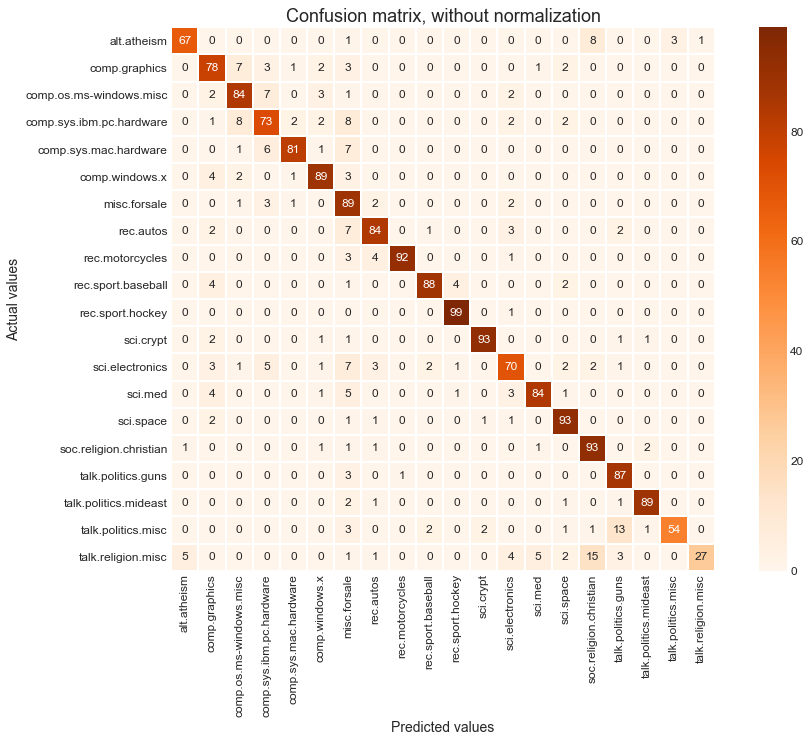

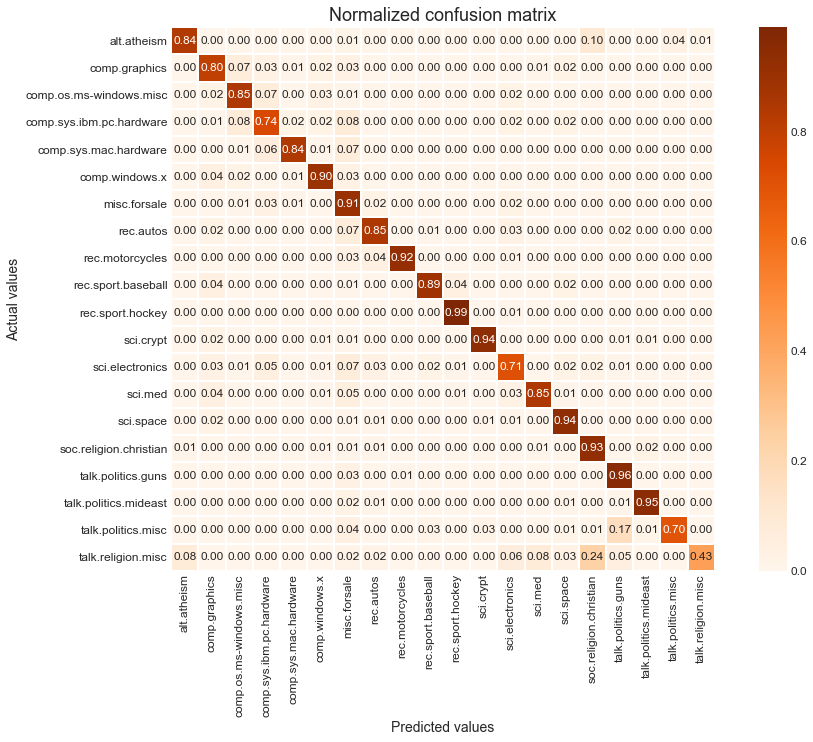

In [89]:
cnf_matrix = confusion_matrix(y_test, y_pred)
# Plot non-normalized confusion matrix
show_confusion_matrix(cm = cnf_matrix, classes = target_names ,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
show_confusion_matrix(cm = cnf_matrix, classes = target_names, normalize=True,
                      title='Normalized confusion matrix')

By looking at the confusion matrix it is quite clear that the classifier performs reasonably well. 
However, the normalized confusion matrix gives a clearer picture of the abilities of the classifier. We thought that comparison of these two matrices was important to illustrate how the raw confusion matrix can sometimes be misleading (some might even say confusing... :) ).

For instance, just by looking at the initial confusion matrix it seems that *alt.atheism* is classified far worse than *rec.sport.hockey* as it is a lot lighter in color. The normalized confusion matrix shows that this is not the case, but that the percentage of data points that belong to the alt.atheism class and are correctly classified is quite similar to the percentage of data points that belong to *rec.sport.hockey* and are correctly classified! The initial confusion matrix can be deceiving when the number of points in different classes vary. In this case classes that have fewer data points overall may seem to be less accurately classified.

The classifier seems to have struggled the most with predicting the correct labels for the *talk.religion.misc* class.

The normalized confusion matrix proves that our classifier predicts labels quite well. Most of the misclassified data entries only affect a very small percentage of the given class, often under 5%. Some interesting examples of misclassification can be found in the *talk.politics.misc* and *talk.religion.misc* rows. 
Some *talk.politics.misc* points are misclassified as *talk.politics.guns*, 17% to be exact, while 24% of *talk.religion.misc* are misclassified as *soc.religion.christian*. Also 10% of *alt.atheism* points are misclassified as *soc.religion.christian*. 
This is not an incredibly inaccurate classification, as the both pairs of subject matters are extremely closely related, *talk.politics.misc* probably contains many words that are also contained in the *talk.politics.guns* points, and the same is true for *talk.religion.misc*, *alt.atheism* and *soc.religion.christian*.

We can conclude that our classifier manages to label most of the data correctly, but appears to struggle with the accurate classification of subjects that cover closely related topics. This could be due to the fact that our dataset contains a wide variety of different subject matters. While the IDF reduces the importance of terms that are very frequent in the entire document collection, it cannot reduce the importance of words that are frequent in specific closely related subjects (but not highly frequent in the overall document collection).


Next, we analyzed the feature importance of words found in the test dataset. The feature importances get a score telling us how important each feature was in classifying, the higher the value, the more important the feature.

In [90]:
feat_imp = pd.DataFrame.from_dict(tfidf_features.vocabulary_, orient='index')
feat_imp = feat_imp.reset_index().set_index(0, drop=True).sort_index()
feat_imp.columns = ['Word']
feat_imp['Importance'] = grid_search.best_estimator_.feature_importances_
feat_imp.sort_values('Importance', ascending=False).head()

,Word,Importance
0,,
65684,dod,0.005460
139570,sale,0.005171
165812,windows,0.004959
46061,bike,0.004800
55485,clipper,0.004789


The most important features that were crucial for our classifier were the words *dod* (short for the United States Department of Defense), *sale*, and *windows*.

After looking at the most important features, we wanted to see how many features were of no use while classifying the data.
To do this, we simply found how many features had an importance of 0.

In order to explore these features further, we decided to take a peek at the values contained here, by looking at the head and tail of these values.

In [91]:
# find words with the lowest importance
least_important = feat_imp[feat_imp['Importance'] == 0]
print(least_important.shape)
least_important.head()

(96918, 2)


,Word,Importance
0,,
4,000000,0.0
5,00000000,0.0
8,00000000b,0.0
9,00000001,0.0
10,00000001b,0.0


In [92]:
least_important.tail()

,Word,Importance
0,,
173753,élangea,0.0
173754,érale,0.0
173755,ête,0.0
173758,ñaustin,0.0
173761,ÿhooked,0.0


As can be seen above, the words with an importance value of 0 are varying, but are all poor predictiors of the class of the data point that they belong to.

It is very interesting to note that a large number (96918) of features are not useful at all, and so have an importance of 0. If we were to continue our analysis, these features could be removed from the model.

The *show_bar_features()* method is used to visualize the distribution of most important features. The values are the same as in the dataframe above, they respresent the average importance of each feature in the created forest.

In [93]:
# add a bar chart for feature importance
def show_bar_features(df, x_col, y_col, title):
    plt.figure(figsize=(16, 8))
    ax = sns.barplot(x = x_col,  y = y_col, data = df, palette = 'Oranges_d')
    ax.set_title(title)
    for p in ax.patches:
        ax.annotate('%.7f' % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height() + 0.0002),
                 ha='center', va='center', fontsize=11, color='black', rotation=90, xytext=(0, 20),
                 textcoords='offset points')

We chose to display the top 20 most important features, in order to get a better feel for the words that are critical for differentiating classes.

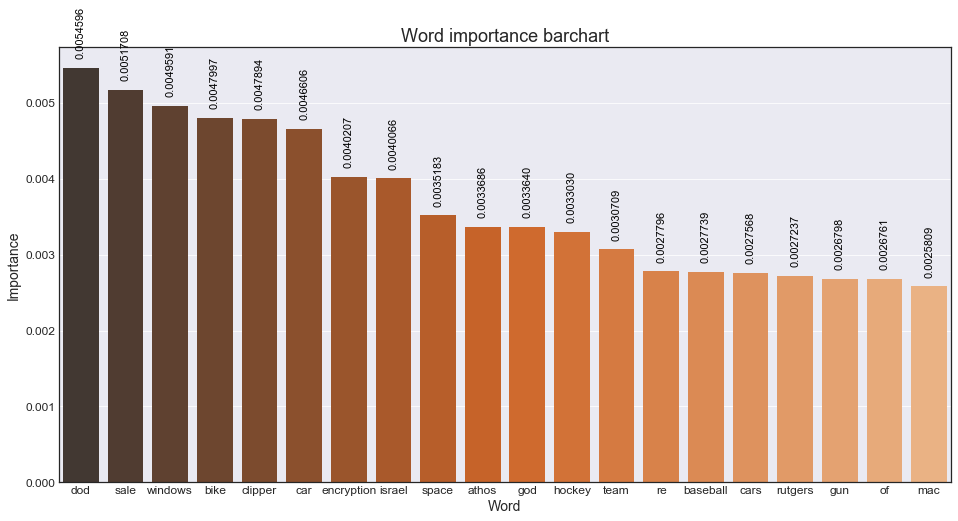

In [94]:
show_bar_features(feat_imp.sort_values('Importance', ascending=False).head(20), 'Word', 'Importance', 'Word importance barchart')

From the plot above, it is interesting to see that words like *windows*, *god* and *hockey* have high importances.
This corresponds very nicely with the results that can be seen in the normalized confusion matrix, where the data points belonging to the *comp* class, and in particular the *comp.windows.x* class, are correctly classified in the vast majority of cases. The same can be said for the *rec.sport.hockey* class, and the *talk.politics* classes, with the exception of the *talk.politics.misc*, which we discussed above. These words have high importances as they are subject specific and are utilized to differentiate classes.

Next we wanted to see how uniformly these importances are distributed over our forest, for this we plotted another bar plot of the top 20 most important features, with the y axis again representing their mean importances over all trees in the forest, but this time with the added benefit of error bars.
The inspiration for this was found on the following [link]( http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py).


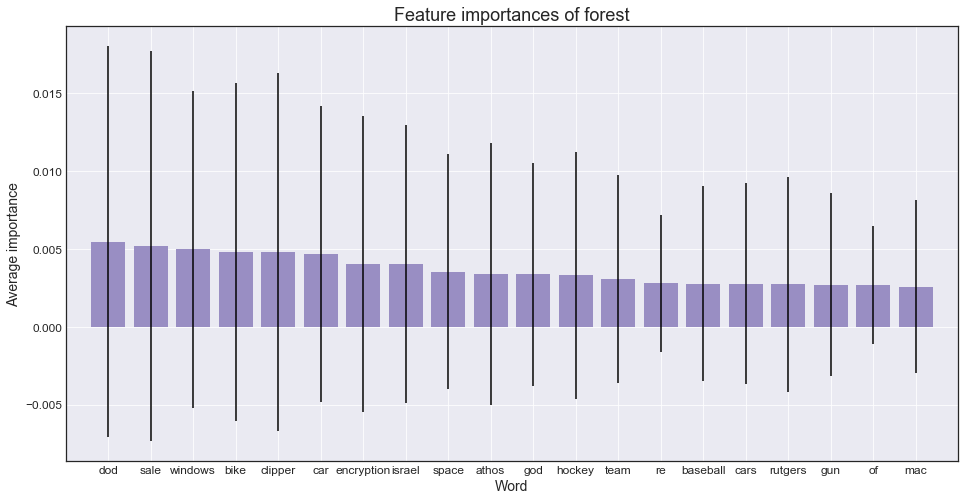

In [95]:
# top 20 most important features in forest 
number_of_features = 20
importances_in_trees = np.array([tree.feature_importances_ for tree in grid_search.best_estimator_.estimators_])
mean_in_trees = np.mean(importances_in_trees, axis = 0)
std_in_trees = np.std(importances_in_trees, axis = 0)
sorted_order = np.argsort(mean_in_trees)[::-1]
mean_in_trees = np.sort(mean_in_trees)[::-1][:number_of_features]
std_in_trees = std_in_trees[sorted_order][:number_of_features]

# Plot the feature importances of the forest
plt.figure(figsize=(16, 8))
plt.title("Feature importances of forest")
plt.bar(range(number_of_features), mean_in_trees,
       color='#998ec3', yerr = std_in_trees, align = 'center')
plt.xticks(range(number_of_features), np.array(tfidf_features.get_feature_names())[sorted_order][:number_of_features])
plt.xlim([-1, number_of_features])
plt.xlabel('Word')
plt.ylabel('Average importance')
plt.show()

Plotting the error bars has given us a more detailed look at the way the different trees in the forest classified data points according to key features. It is now clear that there is a high degree of variance in feature importance between the trees, which is not all that surprising considering that our classifier utilized a forest of 700 trees!